In [1]:
import pandas as pd
import os
from glob import glob
import json
import re
import numpy as np
from tqdm import tqdm

In [2]:
# set working directory
#os.chdir('/project/cper_neon_aop/cper_pdog_uas')

# set whether to pull full tiles from external disk
#external_path = None
external_path = '/mnt/d/202109'
res = 2
outDIR = './cnn_test_results_' + str(res) + 'cm/'


if not os.path.exists(outDIR):
    os.mkdir(outDIR)

idx = 0
for d in glob('./cnn_results_*' + str(res) + 'cm'):
    f_list = glob(d + '/best_model_*_validation.txt')
    f_list = [f for f in f_list if not 'downscaled' in f and not 'old' in f]
    for f in f_list:
        with open(f, 'r') as src:
            val_dat = src.read()
            df_tmp = pd.DataFrame(json.loads(re.sub('nan', '"nan"', '"'.join(val_dat.split("'")))), index=[0])
            df_tmp['model'] = d.split('_')[-2]
            df_tmp['inputs'] = ','.join(os.path.basename(f).split('_')[2:-1])
            df_tmp['min_rp'] = df_tmp[['precision', 'recall']].min(axis=1)
            if idx == 0:
                df_val = df_tmp
            else:
                df_val = pd.concat([df_val, df_tmp])
            idx += 1

In [3]:
# get number of inputs for each model for plotting
df_val['n_inputs'] = df_val['inputs'].apply(lambda x: len(x.split(',')))

In [4]:
# recompute fscore-beta manually if needed
#df_val['fscore_old'] = df_val['fscore']
beta = 1.0
df_val['fscore_beta'] = df_val.apply(lambda x: ((1 + beta) * x['recall'] * x['precision']) / (x['recall'] + beta * x['precision']), axis=1)

In [5]:
# subset results to only rgb, dsm, ndvi
#df_val = df_val[['tpi' not in x and 'shade' not in x for x in df_val['inputs'].apply(lambda x: x.split(','))]].copy()

In [6]:
# get average scores by inputs
df_val['fscore_avg_inputs'] = df_val.groupby('inputs')['fscore'].transform(lambda x: x.mean())
df_val['min_rp_avg_inputs'] = df_val.groupby('inputs')['min_rp'].transform(lambda x: x.mean())

In [7]:
df_val.sort_values('fscore', ascending=False)

,mccloss,iou_score,accuracy,precision,recall,fscore,fscore_burrow,fscore_old,best_epoch,resolution,model,inputs,min_rp,n_inputs,fscore_beta,fscore_avg_inputs,min_rp_avg_inputs
0,0.750231,0.809255,0.994734,0.918971,0.879875,0.898998,0.927390,0.855758,12,2.0,deeplabplus,"rgb,tpi",0.879875,2,0.898998,0.898998,0.879875
0,0.760360,0.807049,0.993677,0.888068,0.907203,0.897533,0.932558,0.852683,12,2.0,deeplabplus,"rgb,tpi,ndvi",0.888068,3,0.897533,0.897533,0.888068
0,0.778918,0.774820,0.993675,0.899402,0.865157,0.881947,0.886046,0.816999,16,2.0,deeplabplus,tpi,0.865157,1,0.881947,0.881947,0.865157
0,0.788929,0.746163,0.993077,0.886531,0.844183,0.864839,0.860207,0.790437,16,2.0,deeplabplus,rgb,0.844183,1,0.864839,0.864839,0.844183
0,0.808036,0.741482,0.992263,0.862929,0.850031,0.856431,0.842119,0.780626,12,2.0,deeplabplus,"rgb,ndvi",0.850031,2,0.856431,0.856431,0.850031
0,0.944572,0.523957,0.988187,0.759840,0.687195,0.721694,0.551680,0.538517,16,2.0,deeplabplus,ndvi,0.687195,1,0.721694,0.721694,0.687195


In [8]:
df_val_pretty = df_val[['inputs', 'precision', 'recall', 'fscore_beta', 'fscore_burrow']].sort_values('fscore_burrow', ascending=False)
df_val_pretty['inputs'] = df_val_pretty['inputs'].apply(lambda x: re.sub(',', ' + ', x.upper()))
df_val_pretty = df_val_pretty.rename(columns={
    'inputs': 'Inputs',
    'precision': 'Precision',
    'recall': 'Recall',
    'fscore_beta': 'F-score (pixels)',
    'fscore_burrow': 'F-score (burrows)'
})
display(df_val_pretty.round(2))

,Inputs,Precision,Recall,F-score (pixels),F-score (burrows)
0,RGB + TPI + NDVI,0.89,0.91,0.90,0.93
0,RGB + TPI,0.92,0.88,0.90,0.93
0,TPI,0.90,0.87,0.88,0.89
0,RGB,0.89,0.84,0.86,0.86
0,RGB + NDVI,0.86,0.85,0.86,0.84
0,NDVI,0.76,0.69,0.72,0.55


### Plot validation results

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

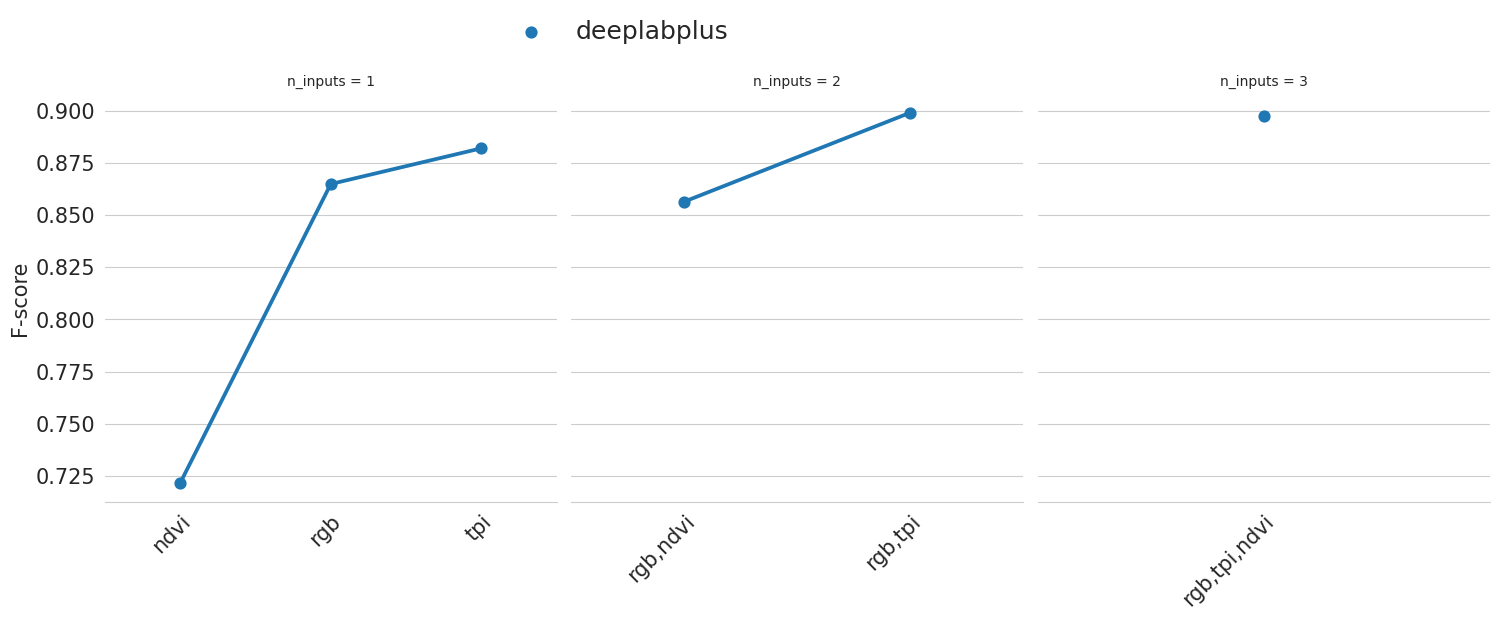

In [10]:
sns.set_style("whitegrid")
g = sns.catplot(x='inputs', y='fscore', 
            hue='model', col='n_inputs', sharex=False,
            data=df_val.sort_values(['n_inputs', 'fscore_avg_inputs']),
            kind='point',
            ci=None, 
            #facet_kws=dict(gridspec_kws=dict(width_ratios=[0.8, 1.8, 1.7, 1.0, 0.5])),
            legend=False,
            legend_out=True)
sns.despine(left=True)
g.set_ylabels('F-score', fontsize=15)
for ax in g.axes.flatten():
    #ax.axes.tick_params(axis='x', rotation=45, ha='right')
    ax.set_xlabel('')
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor", fontsize=15)
    plt.setp(ax.get_yticklabels(), fontsize=15)
g.add_legend(bbox_to_anchor=(0.35, 1.1), loc='upper center', 
             borderaxespad=0, ncol=4, fontsize=18)
#plt.savefig('./results_figs/cnn_results_summary_fscore.png',
#            dpi=600, bbox_inches='tight', pad_inches=0.1)
plt.show()
#plt.close()
#plt.legend(bbox_to_anchor=(0.0, 1.02), loc='upper center', borderaxespad=0)

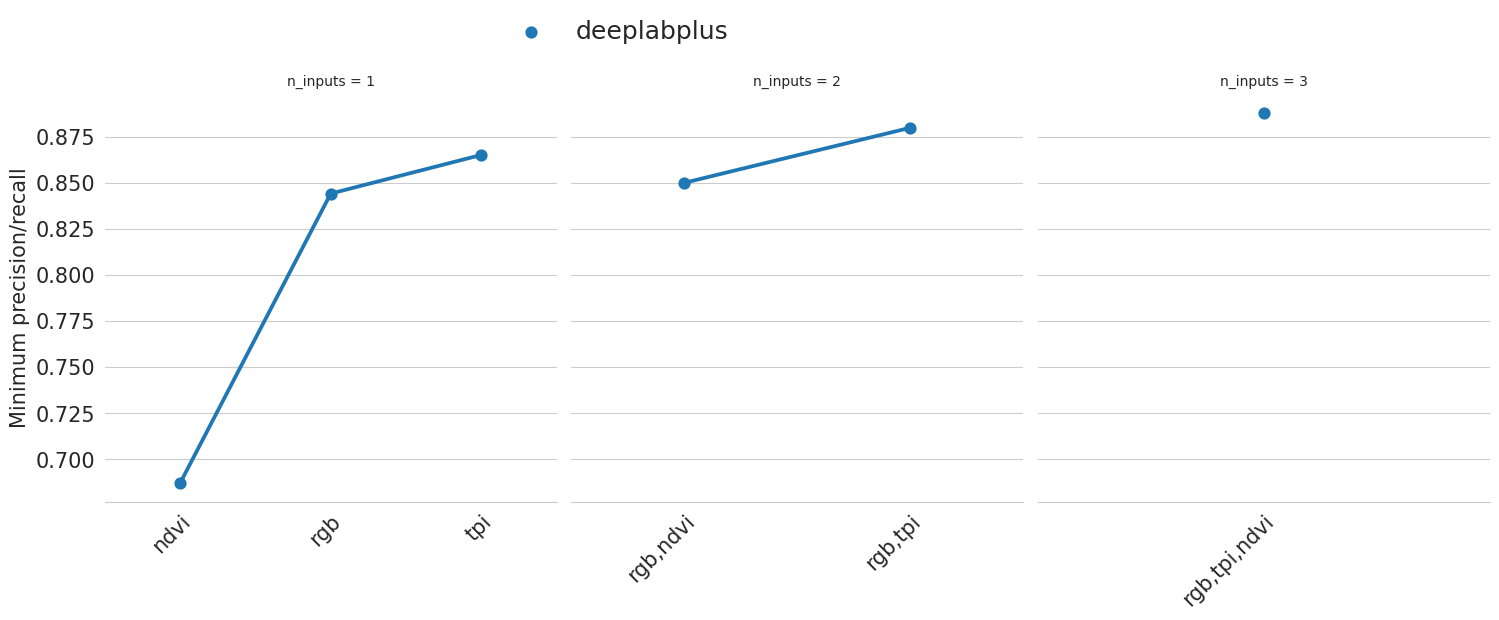

In [11]:
plt.close()
sns.set_style("whitegrid")
g = sns.catplot(x='inputs', y='min_rp', 
            hue='model', col='n_inputs', sharex=False,
            data=df_val.sort_values(['n_inputs', 'fscore_avg_inputs']),
            kind='point',
            ci=None, 
            #facet_kws=dict(gridspec_kws=dict(width_ratios=[0.8, 1.8, 1.7, 1.0, 0.5])),
            legend=False,
            legend_out=True)
sns.despine(left=True)
g.set_ylabels('Minimum precision/recall', fontsize=15)
for ax in g.axes.flatten():
    #ax.axes.tick_params(axis='x', rotation=45, ha='right')
    ax.set_xlabel('')
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor", fontsize=15)
    plt.setp(ax.get_yticklabels(), fontsize=15)
g.add_legend(bbox_to_anchor=(0.35, 1.1), loc='upper center', 
             borderaxespad=0, ncol=4, fontsize=18)
#plt.savefig('./results_figs/cnn_results_summary_minrp.png',
#            dpi=600, bbox_inches='tight', pad_inches=0.1)
plt.show()

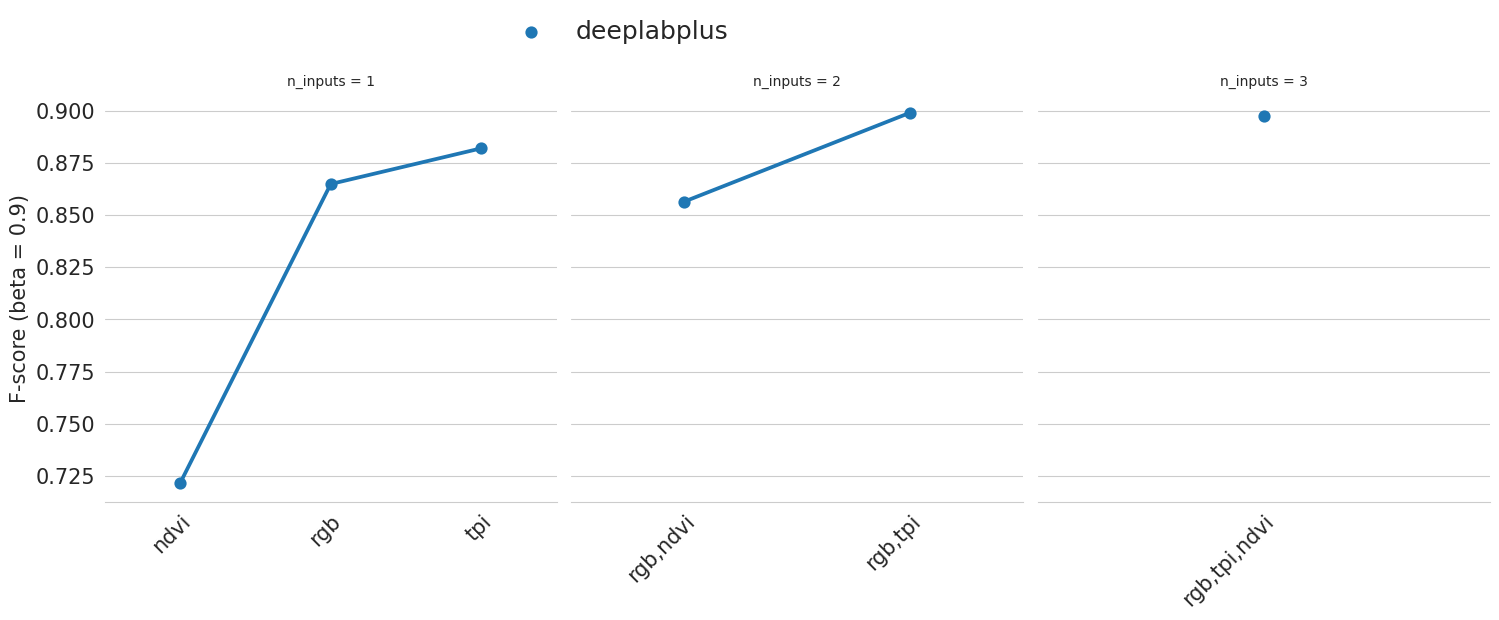

In [12]:
sns.set_style("whitegrid")
g = sns.catplot(x='inputs', y='fscore_beta', 
            hue='model', col='n_inputs', sharex=False,
            data=df_val.sort_values(['n_inputs', 'fscore_avg_inputs']),
            kind='point',
            ci=None, 
            #facet_kws=dict(gridspec_kws=dict(width_ratios=[0.8, 1.8, 1.7, 1.0, 0.5])),
            legend=False,
            legend_out=True)
sns.despine(left=True)
g.set_ylabels('F-score (beta = 0.9)', fontsize=15)
for ax in g.axes.flatten():
    #ax.axes.tick_params(axis='x', rotation=45, ha='right')
    ax.set_xlabel('')
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor", fontsize=15)
    plt.setp(ax.get_yticklabels(), fontsize=15)
g.add_legend(bbox_to_anchor=(0.35, 1.1), loc='upper center', 
             borderaxespad=0, ncol=4, fontsize=18)
#plt.savefig('./results_figs/cnn_results_summary_fscore_beta.png',
#            dpi=600, bbox_inches='tight', pad_inches=0.1)
plt.show()
#plt.close()
#plt.legend(bbox_to_anchor=(0.0, 1.02), loc='upper center', borderaxespad=0)

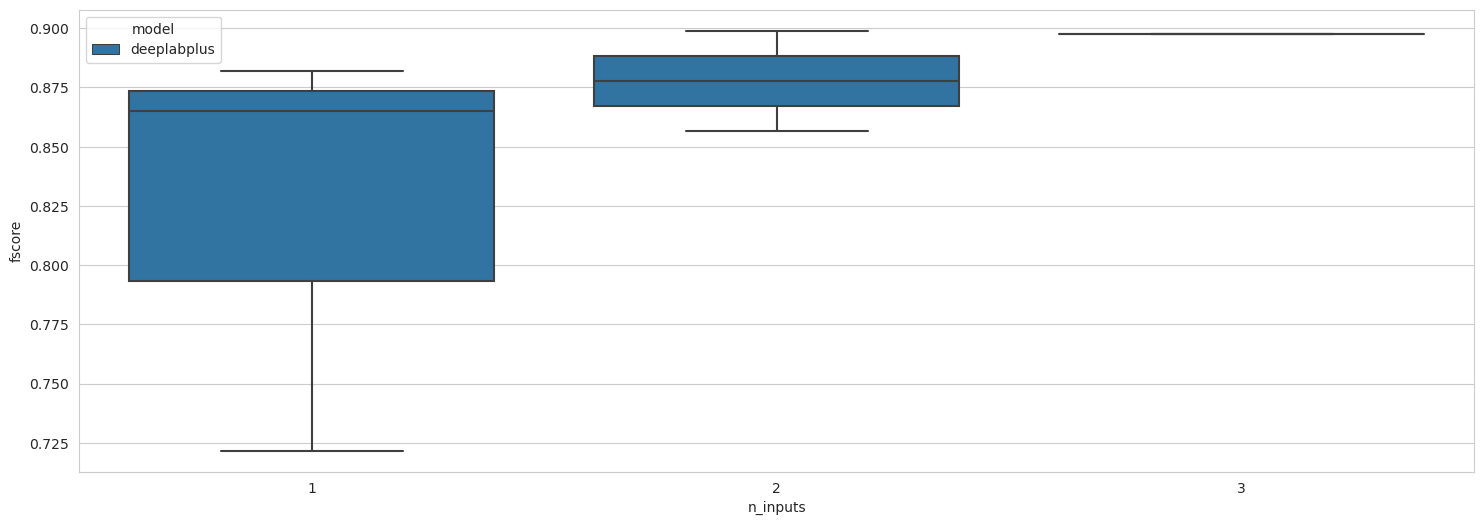

In [13]:
plt.close()
plottype = 'box'
var = 'fscore'
fig, ax = plt.subplots(figsize=(18, 6))
if plottype == 'point':
    sns.pointplot(x='n_inputs', y=var, 
                hue='model',
                data=df_val,
                  dodge=0.1,
                #ci=None,
                ax=ax)
elif plottype == 'box':
    sns.boxplot(x='n_inputs', y=var, 
                hue='model',
                data=df_val,
                ax=ax)
#plt.savefig('./results_figs/cnn_results_summary_avg_' + var + '.png',
#        dpi=600, bbox_inches='tight', pad_inches=0.1)
plt.show()

In [14]:
df_val[df_val['model'] == 'deeplabplus'].sort_values(['fscore'], ascending=False)

,mccloss,iou_score,accuracy,precision,recall,fscore,fscore_burrow,fscore_old,best_epoch,resolution,model,inputs,min_rp,n_inputs,fscore_beta,fscore_avg_inputs,min_rp_avg_inputs
0,0.750231,0.809255,0.994734,0.918971,0.879875,0.898998,0.927390,0.855758,12,2.0,deeplabplus,"rgb,tpi",0.879875,2,0.898998,0.898998,0.879875
0,0.760360,0.807049,0.993677,0.888068,0.907203,0.897533,0.932558,0.852683,12,2.0,deeplabplus,"rgb,tpi,ndvi",0.888068,3,0.897533,0.897533,0.888068
0,0.778918,0.774820,0.993675,0.899402,0.865157,0.881947,0.886046,0.816999,16,2.0,deeplabplus,tpi,0.865157,1,0.881947,0.881947,0.865157
0,0.788929,0.746163,0.993077,0.886531,0.844183,0.864839,0.860207,0.790437,16,2.0,deeplabplus,rgb,0.844183,1,0.864839,0.864839,0.844183
0,0.808036,0.741482,0.992263,0.862929,0.850031,0.856431,0.842119,0.780626,12,2.0,deeplabplus,"rgb,ndvi",0.850031,2,0.856431,0.856431,0.850031
0,0.944572,0.523957,0.988187,0.759840,0.687195,0.721694,0.551680,0.538517,16,2.0,deeplabplus,ndvi,0.687195,1,0.721694,0.721694,0.687195


### Dataloader
Writing helper class for data extraction, tranformation and preprocessing

In [15]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
from skimage import io
import torch
import segmentation_models_pytorch as smp
from segmentation_models_pytorch import utils
import gc

In [16]:
class Dataset(BaseDataset):
    """Read images, apply augmentation and preprocessing transformations.
    
    Args:
        ids (list): list of unique ids for all images
        images_path (str): path to data images
        masks_path (str): path to label masks
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    
    CLASSES = ['other', 'burrow']
    
    def __init__(
            self, 
            ids,
            suffix_list,
            images_path,
            masks_path, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
            suffix_dict = {
        'rgb': {'channels': 3,
                'dtype': 'uint8'},
        'tpi': {'channels': 1,
                'dtype': 'float32'},
        'dsm': {'channels': 1,
                'dtype': 'float32'},
        'shade': {'channels': 1,
                  'dtype': 'float32'},
        'ndvi': {'channels': 1,
                  'dtype': 'float32'}
    }
    ):
        # get IDs as attribute
        self.ids = ids
        
        # get suffix info
        self.suffix_dict = suffix_dict
        
        # get list of suffixes as attribute
        self.suffix_list = suffix_list
        
        # List of files
        self.images_fps = []
        self.masks_fps = [masks_path.format(id) for id in ids]
        for id in ids:
            self.images_fps.append({s: images_path.format(id, s) for s in suffix_list})
            
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image_list = []
        self.image_dict = {}
        for s in self.suffix_list:
            image_s = np.asarray(io.imread(self.images_fps[i][s]), dtype=self.suffix_dict[s]['dtype'])
            if len(image_s.shape) == 2:
                image_s = np.expand_dims(image_s, axis=-1)
            image_s[np.isnan(image_s)] = 0
            if s == 'ndvi':
                image_s[image_s < 0] = 0
            if self.preprocessing:
                image_s = normalize_fn(image_s, s, image_stats)
            image_list.append(image_s)
            self.image_dict[s] = image_s
        if len(image_list) == 1:
            image = image_list[0]
        else:
            image = np.concatenate(image_list, axis=-1)
        mask = np.asarray(io.imread(self.masks_fps[i]), dtype='float32')
        #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #mask = cv2.imread(self.masks_fps[i], 0)
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1)#.astype('float32')
        #print('fetched: ', self.ids[i])
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        # convert final image arrays to tensors
        image = torch.from_numpy(image.transpose(2, 0, 1).astype('float32'))
        mask = torch.from_numpy(mask.transpose(2, 0, 1).astype('float32'))
        return image, mask
        
    def __len__(self):
        return len(self.ids)




In [17]:
# create function to normalize all data in range 0-1
def normalize_fn(image, image_suffix, stats_dict):
    if image_suffix in stats_dict.keys():
        min_tmp = stats_dict[image_suffix]['min']
        max_tmp = stats_dict[image_suffix]['max']
    else:
        # normalize to individual image if min/max stats not specified in dictionary
        min_tmp = np.min(image)
        max_tmp = np.max(image)
    return (image - min_tmp) / (max_tmp - min_tmp)
    
        

## Test best model

### Set parameters and datasets

In [18]:
from random import sample, seed
from shapely.geometry import Polygon, MultiPolygon
import json
import itertools
import geopandas as gpd
import rasterio as rio
from rasterio.features import rasterize
from rasterio import mask
from rasterio.plot import show
import shapely.wkt as wkt
from rasterio.enums import Resampling
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops
import torch.nn as nn
from xrspatial import convolution, focal
from skimage.transform import resize
from rasterio.transform import Affine
import xarray as xr
import rioxarray as riox

In [19]:
ENCODER = 'resnet34'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['burrow']
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation
DEVICE = 'cuda'# 'cpu'# 

In [20]:
# set directories for training data and labels
DATA_FOLDER = './cnn_train_images_' + str(res) + 'cm/{}_{}.tif'
LABEL_FOLDER = './cnn_train_labels_' + str(res) + 'cm/{}_labels.tif'

In [21]:
# read in csvs with training information
df_tiles = pd.read_csv('train_tiles/train_bboxes_all_assigned.csv')
df_polys = pd.read_csv('train_polys/train_polys_all.csv')

In [22]:
df_polys['geometry'] = df_polys.geometry.apply(lambda x: Polygon(wkt.loads(x)))
gdf_polys = gpd.GeoDataFrame(df_polys, geometry='geometry')
gdf_polys = gdf_polys.set_crs(32613)

In [23]:
# get all ids to be used
label_files = glob(LABEL_FOLDER.replace('{}', '*'))
all_ids = [re.sub('_labels.tif', '', os.path.basename(f)) for f in label_files]
all_tiles = list(set(['_'.join(y.split('_')[-3:]) for y in all_ids]))

In [24]:
# separate training and test data and get paths to files
all_files = glob(DATA_FOLDER.replace('{}', '*'))
all_train_tiles = [x for x in df_tiles.apply(lambda x: '_'.join([x.Pasture, x.Tile]) if x.Train == 1 else '', axis=1) if x != '' and x in all_tiles]
test_tiles = list(set(all_tiles) - set(all_train_tiles))

all_train_ids = [x for x in all_ids if '_'.join(x.split('_')[-3:]) in all_train_tiles]
test_ids = list(set(all_ids) - set(all_train_ids))

seed(321)
valid_ids = sample(all_train_ids, int(np.ceil(len(all_train_ids)*0.2)))
train_ids = list(set(all_train_ids) - set(valid_ids))

train_files = [f for f in all_files if '_'.join(os.path.basename(f).split('_')[:-1]) in train_ids]
valid_files = [f for f in all_files if '_'.join(os.path.basename(f).split('_')[:-1]) in valid_ids]
test_files = [f for f in all_files if '_'.join(os.path.basename(f).split('_')[:-1]) in test_ids]

In [25]:
print(len(train_ids))

512


In [26]:
print(len(valid_ids))

129


In [27]:
print(len(test_ids))

455


In [74]:
len([x for x in train_ids if 'poly' in x])

166

In [75]:
len([x for x in valid_ids if 'poly' in x])

35

In [76]:
len([x for x in test_ids if 'poly' in x])

230

In [61]:
len(gdf_polys)

443

In [77]:
166+35+230

431

In [65]:
df_bboxes_22E = pd.read_csv('train_tiles/train_bboxes_22E.csv')
df_bboxes_22W = pd.read_csv('train_tiles/train_bboxes_22W.csv')
df_bboxes_5W = pd.read_csv('train_tiles/train_bboxes_5W.csv')
df_bboxes_2930 = pd.read_csv('train_tiles/train_bboxes_29-30.csv')
df_bboxes_CN = pd.read_csv('train_tiles/train_bboxes_CN.csv')
df_bboxes_all = pd.concat([df_bboxes_22E, df_bboxes_22W, df_bboxes_5W, df_bboxes_2930, df_bboxes_CN])

In [66]:
df_bboxes_all = df_bboxes_all[df_bboxes_all['Type'] != 'random'].copy()

In [67]:
df_bboxes_all['path_pre'] = df_bboxes_all.apply(lambda x: os.path.join('train_tiles',
                                                                       '_'.join(x[['Pasture', 'Type']]), 
                                                                       '_'.join(x[['Pasture', 'Tile']]) + '_'), axis=1)

In [68]:
gdf_pdog_burrows = gpd.read_file('ground_data/cper_pdog_points_2021Sept_burrows.shp')
gdf_pdog_other = gpd.read_file('ground_data/cper_pdog_points_2021Sept_other.shp')
gdf_pdog_old = gpd.read_file('ground_data/cper_pdog_points_old_2021Sept.shp')
gdf_pdog_non = gpd.read_file('ground_data/cper_pdog_points_non_2021Sept.shp')
gdf_pdog_points = pd.concat([gdf_pdog_burrows, gdf_pdog_other, gdf_pdog_old, gdf_pdog_non], ignore_index=True)

In [69]:
gdf_plots = gpd.read_file('ground_data/cper_pdog_polys_2021Sept.shp')
gdf_plots_non = gpd.read_file('ground_data/cper_pdog_polys_non_2021Sept.shp')
gdf_plots_old = gpd.read_file('ground_data/cper_pdog_polys_old_2021Sept.shp')
gdf_plots_all = pd.concat([gdf_plots, gdf_plots_non, gdf_plots_old], ignore_index=True)

In [70]:
# load the image stats from the training data
df_image_stats = pd.read_csv('./_utils/image_stats_' + str(res) + 'cm.csv').set_index('stat')

# convert image stats dictionary to dataframe
image_stats = {i: {'min': df_image_stats.loc['min', i],
                   'max': df_image_stats.loc['max', i]} for i in df_image_stats.columns}

In [71]:
image_stats

{'rgb': {'min': 0.0, 'max': 255.0},
 'tpi': {'min': -0.1, 'max': 0.4},
 'ndvi': {'min': 0.0, 'max': 1.0}}

### Test each model and save results

In [72]:
from dask.distributed import LocalCluster, Client
cluster = LocalCluster(n_workers=8, threads_per_worker=2)
client = Client(cluster)
display(client)

/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/distributed/node.py:180: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 36711 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:36711/status,
Dashboard: http://127.0.0.1:36711/status,Workers: 8
Total threads: 16,Total memory: 15.49 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40623,Workers: 8
Dashboard: http://127.0.0.1:36711/status,Total threads: 16
Started: Just now,Total memory: 15.49 GiB
Comm: tcp://127.0.0.1:43511,Total threads: 2
Dashboard: http://127.0.0.1:35613/status,Memory: 1.94 GiB
Nanny: tcp://127.0.0.1:44643,


In [73]:
model_dict = {
    0: {'model': 'deeplabplus',
        'inputs': ['rgb', 'tpi', 'ndvi']},
    1: {'model': 'deeplabplus',
        'inputs': ['rgb', 'tpi']},
    2: {'model': 'deeplabplus',
        'inputs': ['rgb', 'ndvi']},
    3: {'model': 'deeplabplus',
        'inputs': ['tpi']},
    4: {'model': 'deeplabplus',
        'inputs': ['rgb']},
}

for model_run in model_dict:
    model_fnl = model_dict[model_run]['model']
    inputs_fnl = model_dict[model_run]['inputs']
    print(model_fnl, ': ', '_'.join(inputs_fnl))
    outDIR_mod = os.path.join(outDIR, '_'.join([model_fnl] + inputs_fnl))
    if not os.path.exists(outDIR_mod):
        os.mkdir(outDIR_mod)

        # load best saved checkpoint
        best_model = torch.load('./cnn_results_' + model_fnl + '_' + str(res) + 'cm/best_model_' + '_'.join(inputs_fnl) + '.pth')

        # test dataset without transformations for image visualization
        test_dataset = Dataset(
            test_ids,
            inputs_fnl,
            DATA_FOLDER,
            LABEL_FOLDER,
            preprocessing=True,
            classes=CLASSES)

        test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)

        best_model.eval()

        with torch.no_grad():
            prediction = best_model.forward(next(iter(test_dataloader))[0].cuda())

        test_metrics = [
            utils.metrics.IoU(threshold=0.5),
            utils.metrics.Accuracy(threshold=0.5),
            utils.metrics.Precision(threshold=0.5),
            utils.metrics.Recall(threshold=0.5),
            utils.metrics.Fscore(threshold=0.5)
        ]

        loss = smp.losses.MCCLoss()
        loss.__name__ = 'mccloss'

        # evaluate model on test set
        print('...running pixel-scale test validation')
        if True:
            test_epoch = utils.train.ValidEpoch(
                model=best_model,
                loss=loss,
                metrics=test_metrics,
                device=DEVICE,
                verbose=True,
            )

            logs = test_epoch.run(test_dataloader)
            logs['model'] = model_fnl
            logs['inputs'] = inputs_fnl
            with open(os.path.join(outDIR_mod, 'test_valid_pixel.json'), 'w') as dst:
                json.dump(logs, dst)

        preprocess = True

        precision_list = []
        recall_list = []

        burrow_ct_gt = []
        burrow_ct_pred = []
        tile_id_list = []
        print('...running burrow-scale test validation')
        for ID in tqdm(df_tiles['ID'][(df_tiles['Train'] == 0) &
                                 (df_tiles['Digitize'] == 1)]):
            if all(df_tiles[df_tiles['ID'] == ID]['Train'] == 1):
                continue
            else:
                #print(ID)
                # get the path base to the imagery associated with the training tile
                if external_path is None:
                    tilePATH = df_tiles[df_tiles['ID'] == ID]['path_pre'].iloc[0]
                else:
                    tilePATH = os.path.join(external_path,
                                            df_tiles[df_tiles['ID'] == ID]['path_pre'].iloc[0])
                # get the x/y coordinates of the bounding box for the training polygon within the tile
                box_coords_x = df_tiles[df_tiles['ID'] == ID][['min_x', 'max_x']].iloc[0].values
                box_coords_y = df_tiles[df_tiles['ID'] == ID][['min_y', 'max_y']].iloc[0].values
                # get the box coordinate pairs
                ll, ul, lr, ur = list(itertools.product(box_coords_x, box_coords_y))
                # create a polygon from the coordinate pairs
                tile_geom = Polygon([ll, ul, ur, lr])
                # create the full path to the RGB image of the training tile
                rgb_path = tilePATH + 'rgb.tif'
                with rio.open(rgb_path) as src_rgb:   
                    rgb_out, transform_out = mask.mask(src_rgb,
                                                       [tile_geom],
                                                       crop=True)
                    rgb_out = rgb_out.astype('float')
                    ll_i = src_rgb.index(*ll)
                    ur_i = src_rgb.index(*ur)
                    gdf_polys_sub = gdf_polys[gdf_polys['Tile'] == ID]
                    if len(gdf_polys_sub) > 0:
                        label_mask = rasterize(gdf_polys_sub.geometry, 
                                          out_shape=rgb_out.shape[1:], transform=transform_out,
                                          default_value=1)
                    else:
                         label_mask = np.zeros_like(rgb_out[0, :, :])   
                
                newsize_r = int(round((box_coords_y[1] - box_coords_y[0]) / (res * 0.01), 0))
                newsize_c = int(round((box_coords_x[1] - box_coords_x[0]) / (res * 0.01), 0))
                rgb_out = resize(rgb_out.transpose((1, 2, 0)),
                                 (newsize_r, newsize_c, 3), 
                                 anti_aliasing=True, 
                                 order=1).transpose((2, 0, 1))
                label_mask = label_mask.astype('float')
                label_mask = resize(label_mask,
                                 (newsize_r, newsize_c), 
                                 anti_aliasing=True, 
                                 order=1)
                label_mask = label_mask >= 0.5
                label_mask = label_mask.astype('int')
                
                buff_size = 64
                tile_size = 256

                n_row_chunks = int(np.ceil(rgb_out.shape[1]/tile_size))
                n_col_chunks = int(np.ceil(rgb_out.shape[2]/tile_size))

                pr_mask = np.empty_like(rgb_out[0, :, :])
                image_dict = {}
                for suffix in [i for i in inputs_fnl if i != 'rgb']:
                    if suffix != 'tpi':
                        with rio.open(re.sub('rgb', suffix, rgb_path)) as src_i:
                            i_out = src_i.read(out_shape=(
                                src_i.count,
                                src_rgb.meta['height'],
                                src_rgb.meta['width']),
                                               resampling=Resampling.bilinear)
                            image_dict[suffix] = i_out[:, ll_i[1]-1:ur_i[1]+1, ur_i[0]-1:ll_i[0]+1]
                            image_dict[suffix] = resize(image_dict[suffix].transpose((1, 2, 0)), 
                                                        (newsize_r, newsize_c), 
                                                        anti_aliasing=True, 
                                                        order=1).transpose((2, 0, 1))
                    else:
                        dsm_xr_orig = riox.open_rasterio(re.sub('rgb', 'dsm', rgb_path)).squeeze().chunk({'x': newsize_c/5, 
                                                                                                          'y': newsize_r/5})
                        dsm_xr = dsm_xr_orig.sel(x=slice(box_coords_x[0], box_coords_x[1]),
                                             y=slice(box_coords_y[1], box_coords_y[0])).rio.reproject(
                            dsm_xr_orig.rio.crs,
                            shape=(newsize_r, newsize_c),
                            resampling=Resampling.bilinear).chunk({'x': newsize_c/5, 
                                                                   'y': newsize_r/5})
                        # get cell size of the the DSM in prep foro TPI calculation
                        cellsize_x, cellsize_y = convolution.calc_cellsize(dsm_xr)
                        # prepare an annulus kernel with a ring at the specified distances away from focal point
                        outer_radius = "0.75m"
                        inner_radius = "0.25m"
                        kernel = convolution.annulus_kernel(cellsize_x, cellsize_y, outer_radius, inner_radius)
                        # create the TPI image
                        tpi_xr = dsm_xr - focal.apply(dsm_xr, kernel)
                        image_dict[suffix] = np.expand_dims(tpi_xr.values, 0)
                        
                image_sub_dict = {}
                for r in range(n_row_chunks):
                    if (r + 1) * tile_size > rgb_out.shape[1]:
                        r_min = rgb_out.shape[1] - tile_size
                        r_max = rgb_out.shape[1]
                        r_max_comp = rgb_out.shape[1]
                    elif (r + 1) * tile_size + buff_size > rgb_out.shape[1]:
                        r_min = r * tile_size
                        r_max = (r + 1) * tile_size
                        r_max_comp = r_max
                    else:
                        r_min = r * tile_size
                        r_max = (r + 1) * tile_size
                        r_max_comp = r_max + buff_size
                    for c in range(n_col_chunks):
                        image_sub_dict = {}
                        if (c + 1) * tile_size > rgb_out.shape[2]:
                            c_min = rgb_out.shape[2] - tile_size
                            c_max = rgb_out.shape[2]
                            c_max_comp = rgb_out.shape[2]
                        elif (c + 1) * tile_size + buff_size > rgb_out.shape[2]:
                            c_min = c * tile_size
                            c_max = (c + 1) * tile_size
                            c_max_comp = c_max
                        else:
                            c_min = c * tile_size
                            c_max = (c + 1) * tile_size
                            c_max_comp = c_max + buff_size
                        #print(r_min, r_max, c_min, c_max)
                        for k in image_dict:
                            image_sub_dict[k] = image_dict[k][:,
                                                              max(0, r_min-buff_size):r_max_comp, 
                                                              max(0, c_min-buff_size):c_max_comp].astype('float32')
                        if 'rgb' in inputs_fnl:
                            image_sub_dict['rgb'] = rgb_out[:, 
                                                            max(0, r_min-buff_size):r_max_comp, 
                                                            max(0, c_min-buff_size):c_max_comp].astype('float32')
                        if preprocess:
                            for i in image_sub_dict:
                                image_sub_dict[i] = normalize_fn(image_sub_dict[i], i, image_stats)
                        image_list = [image_sub_dict[i] for i in inputs_fnl]
                        image_out = np.concatenate(image_list, axis=0)
                        x_tensor = torch.from_numpy(image_out).to(DEVICE).unsqueeze(0)
                        if type(best_model) == nn.DataParallel:
                            pred_tmp = best_model.module.predict(x_tensor).cpu().detach().numpy().squeeze() > 0.5
                            buff_r_min = buff_size * int(r_min-buff_size > 0)
                            buff_r_max = buff_size * int(r_max+buff_size < rgb_out.shape[1])
                            buff_c_min = buff_size * int(c_min-buff_size > 0)
                            buff_c_max = buff_size * int(c_max+buff_size < rgb_out.shape[2])
                            if pred_tmp.shape[1] > tile_size:
                                pr_mask[r_min:r_max, c_min:c_max] = pred_tmp[buff_r_min:pred_tmp.shape[0]-buff_r_max,
                                                                             buff_c_min:pred_tmp.shape[1]-buff_c_max]
                            else:
                                pr_mask[r_min:r_max, c_min:c_max] = pred_tmp
                        else:
                            pred_tmp = best_model.predict(x_tensor).cpu().detach().numpy().squeeze() > 0.5
                            buff_r_min = buff_size * int(r_min-buff_size > 0)
                            buff_r_max = buff_size * int(r_max+buff_size < rgb_out.shape[1])
                            buff_c_min = buff_size * int(c_min-buff_size > 0)
                            buff_c_max = buff_size * int(c_max+buff_size < rgb_out.shape[2])
                            if pred_tmp.shape[1] > tile_size:
                                pr_mask[r_min:r_max, c_min:c_max] = pred_tmp[buff_r_min:pred_tmp.shape[0]-buff_r_max,
                                                                             buff_c_min:pred_tmp.shape[1]-buff_c_max]
                            else:
                                pr_mask[r_min:r_max, c_min:c_max] = pred_tmp

                # get regions and properties of the ground truth and predictions
                label_labels = label(label_mask)
                label_regions = regionprops(label_labels)
                pr_labels = label(pr_mask)
                pr_regions = regionprops(pr_labels)

                r_ct_pred = 0
                for r in pr_regions:
                    if r.area*src_rgb.meta['transform'][0]**2 > 0.05:
                        y_pr, x_pr = r.centroid
                        precision_list.append(label_mask[int(y_pr), int(x_pr)])
                        r_ct_pred += 1

                r_ct_gt = 0
                for r in label_regions:
                    y_label, x_label = r.centroid
                    recall_list.append(pr_mask[int(y_label), int(x_label)])
                    r_ct_gt += 1
                burrow_ct_gt.append(r_ct_gt)
                burrow_ct_pred.append(r_ct_pred)
                tile_id_list.append(ID)

        precision = np.sum(precision_list) / len(precision_list)
        recall = np.sum(recall_list) / len(recall_list)
        burrow_test_result = {'model': model_fnl,
                              'inputs': inputs_fnl,
                              'precision': precision,
                              'recall': recall,
                              'fscore': (2 * precision * recall) / (precision + recall),
                              'corr': np.corrcoef(burrow_ct_gt, burrow_ct_pred)[0, 1]}

        with open(os.path.join(outDIR_mod, 'test_valid_burrow.json'), 'w') as dst:
            json.dump(burrow_test_result, dst)

        df_burrow_ct_tmp = pd.DataFrame({'tile_id': tile_id_list,
                                        'burrow_ct_gt': burrow_ct_gt,
                                        'burrow_ct_pred': burrow_ct_pred})
        df_burrow_ct_tmp.to_csv(os.path.join(outDIR_mod, 'test_valid_burrow_count.csv'), index=False)

        plt.figure(figsize=(4, 4))
        plt.scatter(x=burrow_ct_gt, y=burrow_ct_pred)
        plt.xlabel('Burrow ct (observed)')
        plt.ylabel('Burrow ct (predicted)')
        plt.plot(np.arange(0, 16), np.arange(0, 16), c='black')
        #obtain m (slope) and b(intercept) of linear regression line
        m, b = np.polyfit(burrow_ct_gt, burrow_ct_pred, 1)
        #add linear regression line to scatterplot 
        plt.plot(np.arange(0, 16), m*np.arange(0, 16)+b, 
                 linestyle='dashed', c='black')

        if True:
            for i in range(len(burrow_ct_gt)):
                plt.text(x=burrow_ct_gt[i]+0.25,
                         y=burrow_ct_pred[i],
                         s=tile_id_list[i])
        plt.savefig(os.path.join(outDIR_mod, 'test_valid_burrow_correlation.png'), dpi=300)
        plt.close()

        ### Test against ground data

        preprocess = True
        df_bboxes_tmp = df_bboxes_all.copy()
        gdf_pdog_points_tmp = gdf_pdog_points.copy()
        print('...running burrow-scale test validation with ground-truth data')
        for ID in tqdm(df_bboxes_all['ID'][df_bboxes_all['Type'] != 'non_burrows']):
            #print(ID)
            # get the path base to the imagery associated with the training tile
            if external_path is None:
                tilePATH = df_bboxes_all[df_bboxes_all['ID'] == ID]['path_pre'].iloc[0]
            else:
                tilePATH = os.path.join(external_path,
                                        df_bboxes_all[df_bboxes_all['ID'] == ID]['path_pre'].iloc[0])
            # get the x/y coordinates of the bounding box for the training polygon within the tile
            box_coords_x = df_bboxes_all[df_bboxes_all['ID'] == ID][['min_x', 'max_x']].iloc[0].values
            box_coords_y = df_bboxes_all[df_bboxes_all['ID'] == ID][['min_y', 'max_y']].iloc[0].values
            # get the box coordinate pairs
            ll, ul, lr, ur = list(itertools.product(box_coords_x, box_coords_y))
            # create a polygon from the coordinate pairs
            tile_geom = Polygon([ll, ul, ur, lr])
            # create the full path to the RGB image of the training tile
            rgb_path = tilePATH + 'rgb.tif'
            with rio.open(rgb_path) as src_rgb:   
                rgb_out, transform_out = mask.mask(src_rgb,
                                                   [tile_geom],
                                                   crop=True)
                rgb_out = rgb_out.astype('float')
                rgb_out_orig = rgb_out.copy()
                ll_i = src_rgb.index(*ll)
                ur_i = src_rgb.index(*ur)
                gdf_polys_sub = gdf_polys[gdf_polys['Tile'] == ID]
                if len(gdf_polys_sub) > 0:
                    label_mask = rasterize(gdf_polys_sub.geometry, 
                                      out_shape=rgb_out.shape[1:], transform=transform_out,
                                      default_value=1)
                else:
                     label_mask = np.zeros_like(rgb_out[0, :, :])   
                newsize_r = int(round((box_coords_y[1] - box_coords_y[0]) / (res * 0.01), 0))
                newsize_c = int(round((box_coords_x[1] - box_coords_x[0]) / (res * 0.01), 0))
                rgb_out = resize(rgb_out.transpose((1, 2, 0)),
                                 (newsize_r, newsize_c, 3), 
                                 anti_aliasing=True, 
                                 order=1).transpose((2, 0, 1))
                label_mask = label_mask.astype('float')
                label_mask = resize(label_mask,
                                 (newsize_r, newsize_c), 
                                 anti_aliasing=True, 
                                 order=1)
                label_mask = label_mask >= 0.5
                label_mask = label_mask.astype('int')

            n_row_chunks = int(np.ceil(rgb_out.shape[1]/tile_size))
            n_col_chunks = int(np.ceil(rgb_out.shape[2]/tile_size))

            pr_mask = np.empty_like(rgb_out[0, :, :])
            image_dict = {}
            for suffix in [i for i in inputs_fnl if i != 'rgb']:
                if suffix != 'tpi':
                    with rio.open(re.sub('rgb', suffix, rgb_path)) as src_i:
                        i_out = src_i.read(out_shape=(
                            src_i.count,
                            src_rgb.meta['height'],
                            src_rgb.meta['width']),
                                           resampling=Resampling.bilinear)
                        image_dict[suffix] = i_out[:, ll_i[1]-1:ur_i[1]+1, ur_i[0]-1:ll_i[0]+1]
                        image_dict[suffix] = resize(image_dict[suffix].transpose((1, 2, 0)), 
                                                    (newsize_r, newsize_c), 
                                                    anti_aliasing=True, 
                                                    order=1).transpose((2, 0, 1))
                else:
                    dsm_xr_orig = riox.open_rasterio(re.sub('rgb', 'dsm', rgb_path)).squeeze().chunk({'x': newsize_c/5, 
                                                                                                      'y': newsize_r/5})
                    dsm_xr = dsm_xr_orig.sel(x=slice(box_coords_x[0], box_coords_x[1]),
                                             y=slice(box_coords_y[1], box_coords_y[0])).rio.reproject(
                        dsm_xr_orig.rio.crs,
                        shape=(newsize_r, newsize_c),
                        resampling=Resampling.bilinear).chunk({'x': newsize_c/5, 
                                                               'y': newsize_r/5})
                    # get cell size of the the DSM in prep foro TPI calculation
                    cellsize_x, cellsize_y = convolution.calc_cellsize(dsm_xr)
                    # prepare an annulus kernel with a ring at the specified distances away from focal point
                    outer_radius = "0.75m"
                    inner_radius = "0.25m"
                    kernel = convolution.annulus_kernel(cellsize_x, cellsize_y, outer_radius, inner_radius)
                    # create the TPI image
                    tpi_xr = dsm_xr - focal.apply(dsm_xr, kernel)
                    image_dict[suffix] = np.expand_dims(tpi_xr.values, 0)
            if 'rgb' in inputs_fnl:
                    image_dict['rgb'] = rgb_out        
            image_sub_dict = {}
            for r in range(n_row_chunks):
                if (r + 1) * tile_size > rgb_out.shape[1]:
                    r_min = rgb_out.shape[1] - tile_size
                    r_max = rgb_out.shape[1]
                    r_max_comp = rgb_out.shape[1]
                elif (r + 1) * tile_size + buff_size > rgb_out.shape[1]:
                    r_min = r * tile_size
                    r_max = (r + 1) * tile_size
                    r_max_comp = r_max
                else:
                    r_min = r * tile_size
                    r_max = (r + 1) * tile_size
                    r_max_comp = r_max + buff_size
                for c in range(n_col_chunks):
                    image_sub_dict = {}
                    if (c + 1) * tile_size > rgb_out.shape[2]:
                        c_min = rgb_out.shape[2] - tile_size
                        c_max = rgb_out.shape[2]
                        c_max_comp = rgb_out.shape[2]
                    elif (c + 1) * tile_size + buff_size > rgb_out.shape[2]:
                        c_min = c * tile_size
                        c_max = (c + 1) * tile_size
                        c_max_comp = c_max
                    else:
                        c_min = c * tile_size
                        c_max = (c + 1) * tile_size
                        c_max_comp = c_max + buff_size
                    #print(r_min, r_max, c_min, c_max)
                    for k in image_dict:
                        image_sub_dict[k] = image_dict[k][:,
                                                          max(0, r_min-buff_size):r_max_comp, 
                                                          max(0, c_min-buff_size):c_max_comp].astype('float32')
                    if 'rgb' in inputs_fnl:
                        image_sub_dict['rgb'] = rgb_out[:, 
                                                        max(0, r_min-buff_size):r_max_comp, 
                                                        max(0, c_min-buff_size):c_max_comp].astype('float32')
                    if preprocess:
                        for i in image_sub_dict:
                            image_sub_dict[i] = normalize_fn(image_sub_dict[i], i, image_stats)
                    image_list = [image_sub_dict[i] for i in inputs_fnl]
                    image_out = np.concatenate(image_list, axis=0)
                    x_tensor = torch.from_numpy(image_out).to(DEVICE).unsqueeze(0)
                    if type(best_model) == nn.DataParallel:
                        pred_tmp = best_model.module.predict(x_tensor).cpu().detach().numpy().squeeze() > 0.5
                        buff_r_min = buff_size * int(r_min-buff_size > 0)
                        buff_r_max = buff_size * int(r_max+buff_size < rgb_out.shape[1])
                        buff_c_min = buff_size * int(c_min-buff_size > 0)
                        buff_c_max = buff_size * int(c_max+buff_size < rgb_out.shape[2])
                        if pred_tmp.shape[1] > tile_size:
                            pr_mask[r_min:r_max, c_min:c_max] = pred_tmp[buff_r_min:pred_tmp.shape[0]-buff_r_max,
                                                                         buff_c_min:pred_tmp.shape[1]-buff_c_max]
                        else:
                            pr_mask[r_min:r_max, c_min:c_max] = pred_tmp
                    else:
                        pred_tmp = best_model.predict(x_tensor).cpu().detach().numpy().squeeze() > 0.5
                        buff_r_min = buff_size * int(r_min-buff_size > 0)
                        buff_r_max = buff_size * int(r_max+buff_size < rgb_out.shape[1])
                        buff_c_min = buff_size * int(c_min-buff_size > 0)
                        buff_c_max = buff_size * int(c_max+buff_size < rgb_out.shape[2])
                        if pred_tmp.shape[1] > tile_size:
                            pr_mask[r_min:r_max, c_min:c_max] = pred_tmp[buff_r_min:pred_tmp.shape[0]-buff_r_max,
                                                                         buff_c_min:pred_tmp.shape[1]-buff_c_max]
                        else:
                            pr_mask[r_min:r_max, c_min:c_max] = pred_tmp

            # create mask of ground-truth polygon
            gt_plot_mask = rasterize(gdf_plots_all.geometry, 
                                     out_shape=rgb_out_orig.shape[1:], 
                                     transform=transform_out,
                                     default_value=1).astype('float')
            gt_plot_mask = resize(gt_plot_mask,
                                 (newsize_r, newsize_c), 
                                 anti_aliasing=True, 
                                 order=1)
            gt_plot_mask = gt_plot_mask >= 0.5
            # get predictions for ground-truth points
            gdf_pdog_points_sub = gdf_pdog_points[gdf_pdog_points.geometry.within(tile_geom)]
            if len(gdf_pdog_points_sub) > 0:
                all_points_mask = rasterize(gdf_pdog_points_sub.geometry.buffer(0.5), 
                                              out_shape=rgb_out_orig.shape[1:], transform=transform_out,
                                              default_value=1).astype('float')      
            else:
                all_points_mask = np.zeros_like(rgb_out[0, :, :]) 
            
            all_points_mask = resize(all_points_mask,
                                 (newsize_r, newsize_c), 
                                 anti_aliasing=True, 
                                 order=1)
            all_points_mask = all_points_mask >= 0.5
            # mask all arrays to ground-truth polygon
            pr_mask = pr_mask * gt_plot_mask
            label_mask = label_mask * gt_plot_mask
            all_points_mask = all_points_mask * gt_plot_mask


            # get regions and properties of the ground truth and predictions
            label_labels = label(label_mask)
            label_regions = regionprops(label_labels)
            pr_labels = label(pr_mask)
            pr_regions = regionprops(pr_labels)

            ground_pred_precision_list = []
            ground_label_precision_list = []
            r_ct_pred = 0
            for r in pr_regions:
                if r.area*src_rgb.meta['transform'][0]**2 > 0.05:
                    y_pr, x_pr = r.centroid
                    ground_pred_precision_list.append(all_points_mask[int(y_pr), int(x_pr)])
                    r_ct_pred += 1

            r_ct_label = 0
            for r in label_regions:
                y_label, x_label = r.centroid
                ground_label_precision_list.append(all_points_mask[int(y_label), int(x_label)])
                r_ct_label += 1

            df_bboxes_tmp.loc[df_bboxes_tmp['ID'] == ID, 'pred_ct'] = len(ground_pred_precision_list)
            df_bboxes_tmp.loc[df_bboxes_tmp['ID'] == ID, 'pred_correct_ct'] = np.sum(ground_pred_precision_list)
            df_bboxes_tmp.loc[df_bboxes_tmp['ID'] == ID, 'label_ct'] = len(ground_label_precision_list)
            df_bboxes_tmp.loc[df_bboxes_tmp['ID'] == ID, 'label_correct_ct'] = np.sum(ground_label_precision_list)
            df_bboxes_tmp.loc[df_bboxes_tmp['ID'] == ID, 'gt_ct'] = len(gdf_pdog_points_sub[gdf_pdog_points_sub['is_burrow'] == 1])

            if len(gdf_pdog_points_sub) > 0:
                for idx, point in gdf_pdog_points_sub.iterrows():
                    point_mask = rasterize([point.geometry.buffer(0.5)], 
                                          out_shape=rgb_out_orig.shape[1:], transform=transform_out,
                                          default_value=1)
                    point_mask = point_mask.astype('float')
                    point_mask = resize(point_mask,
                                 (newsize_r, newsize_c), 
                                 anti_aliasing=True, 
                                 order=1)
                    point_mask = point_mask >= 0.5
                    point_labels = label(point_mask)
                    point_regions = regionprops(point_labels)
                    y_gt, x_gt = point_regions[0].centroid
                    gdf_pdog_points_tmp.loc[idx, 'pred'] = pr_mask[int(y_gt), int(x_gt)]
                    gdf_pdog_points_tmp.loc[idx, 'label'] = label_mask[int(y_gt), int(x_gt)]

        df_bboxes_tmp['model'] = model_fnl
        df_bboxes_tmp['inputs'] = '_'.join(inputs_fnl)
        df_bboxes_tmp.to_csv(os.path.join(outDIR_mod, 'test_valid_bbox_gt.csv'), index=False)

        gdf_pdog_points_tmp['model'] = model_fnl
        gdf_pdog_points_tmp['inputs'] = '_'.join(inputs_fnl)
        gdf_pdog_points_tmp.to_csv(os.path.join(outDIR_mod, 'test_valid_burrow_gt.csv'), index=False)

        del best_model, df_bboxes_tmp, gdf_pdog_points_tmp, logs, burrow_test_result, df_burrow_ct_tmp
        gc.collect()
        torch.cuda.empty_cache()
    else:
        print('Skipping! Combo results already exist.')
        continue

deeplabplus :  rgb_tpi_ndvi
...running pixel-scale test validation
valid: 100%|█| 455/455 [00:31<00:00, 14.44it/s, mccloss - 0.5767, iou_score - 0.6996, accuracy - 0.9902, precision - 0.8
...running burrow-scale test validation


 53%|████████████████████████████████████████████▎                                      | 24/45 [05:27<04:31, 12.91s/it]/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)
 58%|███████████████████████████████████████████████▉                                   | 26/45 [05:54<04:07, 13.04s/it]/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)
100%|███████████████████████████████████

...running burrow-scale test validation with ground-truth data


 21%|█████████████████▍                                                                 | 12/57 [02:54<10:41, 14.26s/it]/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)
 23%|██████████████████▉                                                                | 13/57 [03:08<10:23, 14.18s/it]/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)
 77%|███████████████████████████████████

deeplabplus :  rgb_tpi
...running pixel-scale test validation
valid: 100%|█| 455/455 [00:27<00:00, 16.42it/s, mccloss - 0.5815, iou_score - 0.694, accuracy - 0.9911, precision - 0.90
...running burrow-scale test validation


 53%|████████████████████████████████████████████▎                                      | 24/45 [05:06<04:34, 13.08s/it]/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)
100%|███████████████████████████████████████████████████████████████████████████████████| 45/45 [09:33<00:00, 12.75s/it]


...running burrow-scale test validation with ground-truth data


 77%|████████████████████████████████████████████████████████████████                   | 44/57 [09:32<02:52, 13.25s/it]/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)
 89%|██████████████████████████████████████████████████████████████████████████▎        | 51/57 [11:02<01:16, 12.73s/it]/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)
 95%|███████████████████████████████████

deeplabplus :  rgb_ndvi
...running pixel-scale test validation
valid: 100%|█| 455/455 [00:29<00:00, 15.47it/s, mccloss - 0.652, iou_score - 0.5961, accuracy - 0.9873, precision - 0.82
...running burrow-scale test validation


 53%|████████████████████████████████████████████▎                                      | 24/45 [01:34<01:19,  3.77s/it]/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)
 58%|███████████████████████████████████████████████▉                                   | 26/45 [01:41<01:07,  3.56s/it]/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)
100%|███████████████████████████████████

...running burrow-scale test validation with ground-truth data


 21%|█████████████████▍                                                                 | 12/57 [00:57<03:20,  4.46s/it]/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)
 23%|██████████████████▉                                                                | 13/57 [01:02<03:11,  4.36s/it]/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)
 77%|███████████████████████████████████

deeplabplus :  tpi
...running pixel-scale test validation
valid: 100%|█| 455/455 [00:16<00:00, 28.01it/s, mccloss - 0.5978, iou_score - 0.6793, accuracy - 0.9908, precision - 0.9
...running burrow-scale test validation


 53%|████████████████████████████████████████████▎                                      | 24/45 [04:53<04:21, 12.43s/it]/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)
100%|███████████████████████████████████████████████████████████████████████████████████| 45/45 [09:25<00:00, 12.57s/it]


...running burrow-scale test validation with ground-truth data


 77%|████████████████████████████████████████████████████████████████                   | 44/57 [09:56<02:57, 13.69s/it]/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)
 89%|██████████████████████████████████████████████████████████████████████████▎        | 51/57 [11:29<01:19, 13.26s/it]/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)
 95%|███████████████████████████████████

deeplabplus :  rgb
...running pixel-scale test validation
valid: 100%|█| 455/455 [00:19<00:00, 23.47it/s, mccloss - 0.6487, iou_score - 0.614, accuracy - 0.9879, precision - 0.87
...running burrow-scale test validation


 53%|████████████████████████████████████████████▎                                      | 24/45 [01:12<01:02,  2.95s/it]/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)
100%|███████████████████████████████████████████████████████████████████████████████████| 45/45 [02:15<00:00,  3.01s/it]


...running burrow-scale test validation with ground-truth data


 77%|████████████████████████████████████████████████████████████████                   | 44/57 [02:46<00:54,  4.21s/it]/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)
 89%|██████████████████████████████████████████████████████████████████████████▎        | 51/57 [03:13<00:22,  3.81s/it]/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:725: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/skimage/transform/_warps.py:729: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)
 95%|███████████████████████████████████

In [74]:
print('All processing complete!')

All processing complete!


In [40]:
# load best saved checkpoint
best_model = torch.load('./cnn_results_' + model_fnl + '_' + str(res) + 'cm/best_model_' + '_'.join(inputs_fnl) + '.pth')

# load the image stats from the training data
df_image_stats = pd.read_csv('./_utils/image_stats_' + str(res) + 'cm.csv').set_index('stat')

# convert image stats dictionary to dataframe
image_stats = {i: {'min': df_image_stats.loc['min', i],
                   'max': df_image_stats.loc['max', i]} for i in [x for x in inputs_fnl if x != 'dsm']}

# test dataset without transformations for image visualization
test_dataset = Dataset(
    test_ids,
    inputs_fnl,
    DATA_FOLDER,
    LABEL_FOLDER,
    preprocessing=True,
    classes=CLASSES)

test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)

best_model.eval()

with torch.no_grad():
    prediction = best_model.forward(next(iter(test_dataloader))[0].cuda())

test_metrics = [
    utils.metrics.IoU(threshold=0.5),
    utils.metrics.Accuracy(threshold=0.5),
    utils.metrics.Precision(threshold=0.5),
    utils.metrics.Recall(threshold=0.5),
    utils.metrics.Fscore(threshold=0.5)
]

loss = smp.losses.MCCLoss()
loss.__name__ = 'mccloss'
preprocess = True
ID = '22E_11'
df_bboxes_tmp = df_bboxes_all.copy()
gdf_pdog_points_tmp = gdf_pdog_points.copy()
print('...running burrow-scale test validation with ground-truth data')
if external_path is None:
    tilePATH = df_bboxes_all[df_bboxes_all['ID'] == ID]['path_pre'].iloc[0]
else:
    tilePATH = os.path.join(external_path,
                            df_bboxes_all[df_bboxes_all['ID'] == ID]['path_pre'].iloc[0])
# get the x/y coordinates of the bounding box for the training polygon within the tile
box_coords_x = df_bboxes_all[df_bboxes_all['ID'] == ID][['min_x', 'max_x']].iloc[0].values
box_coords_y = df_bboxes_all[df_bboxes_all['ID'] == ID][['min_y', 'max_y']].iloc[0].values
# get the box coordinate pairs
ll, ul, lr, ur = list(itertools.product(box_coords_x, box_coords_y))
# create a polygon from the coordinate pairs
tile_geom = Polygon([ll, ul, ur, lr])
# create the full path to the RGB image of the training tile
rgb_path = tilePATH + 'rgb.tif'
with rio.open(rgb_path) as src_rgb:   
    rgb_out, transform_out = mask.mask(src_rgb,
                                       [tile_geom],
                                       crop=True)
    rgb_out_orig = rgb_out.copy()
    ll_i = src_rgb.index(*ll)
    ur_i = src_rgb.index(*ur)
    gdf_polys_sub = gdf_polys[gdf_polys['Tile'] == ID]
    if len(gdf_polys_sub) > 0:
        label_mask = rasterize(gdf_polys_sub.geometry, 
                          out_shape=rgb_out.shape[1:], transform=transform_out,
                          default_value=1)
    else:
         label_mask = np.zeros_like(rgb_out[0, :, :])   
    newsize_r = int(round((box_coords_y[1] - box_coords_y[0]) / (res * 0.01), 0))
    newsize_c = int(round((box_coords_x[1] - box_coords_x[0]) / (res * 0.01), 0))
    rgb_out = resize(rgb_out.transpose((1, 2, 0)),
                     (newsize_r, newsize_c, 3), 
                     anti_aliasing=True, 
                     order=1).transpose((2, 0, 1))
    label_mask = label_mask.astype('float')
    label_mask = resize(label_mask,
                     (newsize_r, newsize_c), 
                     anti_aliasing=True, 
                     order=1)
    label_mask = label_mask >= 0.5
    label_mask = label_mask.astype('int')

n_row_chunks = int(np.ceil(rgb_out.shape[1]/256))
n_col_chunks = int(np.ceil(rgb_out.shape[2]/256))

pr_mask = np.empty_like(rgb_out[0, :, :])
image_dict = {}
for suffix in [i for i in inputs_fnl if i != 'rgb']:
    if suffix != 'tpi':
        with rio.open(re.sub('rgb', suffix, rgb_path)) as src_i:
            i_out = src_i.read(out_shape=(
                src_i.count,
                src_rgb.meta['height'],
                src_rgb.meta['width']),
                               resampling=Resampling.bilinear)
            image_dict[suffix] = i_out[:, ll_i[1]-1:ur_i[1]+1, ur_i[0]-1:ll_i[0]+1]
            image_dict[suffix] = resize(image_dict[suffix].transpose((1, 2, 0)), 
                                        (newsize_r, newsize_c), 
                                        anti_aliasing=True, 
                                        order=1).transpose((2, 0, 1))
    else:
        dsm_xr_orig = riox.open_rasterio(re.sub('rgb', 'dsm', rgb_path)).squeeze().chunk({'x': newsize_c/5, 
                                                                                          'y': newsize_r/5})
        dsm_xr = dsm_xr_orig.sel(x=slice(box_coords_x[0], box_coords_x[1]),
                                 y=slice(box_coords_y[1], box_coords_y[0])).rio.reproject(
            dsm_xr_orig.rio.crs,
            shape=(newsize_r, newsize_c),
            resampling=Resampling.bilinear).chunk({'x': newsize_c/5, 
                                                   'y': newsize_r/5})
        # get cell size of the the DSM in prep foro TPI calculation
        cellsize_x, cellsize_y = convolution.calc_cellsize(dsm_xr)
        # prepare an annulus kernel with a ring at the specified distances away from focal point
        outer_radius = "0.75m"
        inner_radius = "0.25m"
        kernel = convolution.annulus_kernel(cellsize_x, cellsize_y, outer_radius, inner_radius)
        # create the TPI image
        tpi_xr = dsm_xr - focal.apply(dsm_xr, kernel)
        image_dict[suffix] = np.expand_dims(tpi_xr.values, 0)
if 'rgb' in inputs_fnl:
        image_dict['rgb'] = rgb_out        
image_sub_dict = {}
for r in range(n_row_chunks):
    if (r + 1) * 256 > rgb_out.shape[1]:
        r_min = rgb_out.shape[1] - 256
        r_max = rgb_out.shape[1]
    else:
        r_min = r * 256
        r_max = (r + 1) * 256
    for c in range(n_col_chunks):
        if (c + 1) * 256 > rgb_out.shape[2]:
            c_min = rgb_out.shape[2] - 256
            c_max = rgb_out.shape[2]
        else:
            c_min = c * 256
            c_max = (c + 1) * 256
        for k in image_dict:
            image_sub_dict[k] = image_dict[k][:, r_min:r_max, c_min:c_max].astype('float32')
        if preprocess:
            for i in image_sub_dict:
                image_sub_dict[i] = normalize_fn(image_sub_dict[i], i, image_stats)
        image_list = [image_sub_dict[i] for i in inputs_fnl]
        image_out = np.concatenate(image_list, axis=0)
        x_tensor = torch.from_numpy(image_out).to(DEVICE).unsqueeze(0)
        if type(best_model) == nn.DataParallel:
            pr_mask[r_min:r_max, c_min:c_max] = best_model.module.predict(x_tensor).cpu().detach().numpy().squeeze() > 0.5
        else:
            pr_mask[r_min:r_max, c_min:c_max] = best_model.predict(x_tensor).cpu().detach().numpy().squeeze() > 0.5
pr_mask = pr_mask.astype('float')
# create mask of ground-truth polygon
gt_plot_mask = rasterize(gdf_plots_all.geometry, 
                         out_shape=rgb_out_orig.shape[1:], 
                         transform=transform_out,
                         default_value=1).astype('float')
gt_plot_mask = resize(gt_plot_mask,
                     (newsize_r, newsize_c), 
                     anti_aliasing=True, 
                     order=1)
gt_plot_mask = gt_plot_mask >= 0.5
# get predictions for ground-truth points
gdf_pdog_points_sub = gdf_pdog_points[gdf_pdog_points.geometry.within(tile_geom)]
if len(gdf_pdog_points_sub) > 0:
    all_points_mask = rasterize(gdf_pdog_points_sub.geometry.buffer(0.5), 
                                  out_shape=rgb_out_orig.shape[1:], transform=transform_out,
                                  default_value=1).astype('float')      
else:
    all_points_mask = np.zeros_like(rgb_out[0, :, :]) 

all_points_mask = resize(all_points_mask,
                     (newsize_r, newsize_c), 
                     anti_aliasing=True, 
                     order=1)
# mask all arrays to ground-truth polygon
pr_mask = pr_mask * gt_plot_mask
label_mask = label_mask * gt_plot_mask
all_points_mask = all_points_mask * gt_plot_mask


# get regions and properties of the ground truth and predictions
label_labels = label(label_mask)
label_regions = regionprops(label_labels)
pr_labels = label(pr_mask)
pr_regions = regionprops(pr_labels)

ground_pred_precision_list = []
ground_label_precision_list = []
r_ct_pred = 0
for r in pr_regions:
    if r.area*res**2 > 0.05:
        y_pr, x_pr = r.centroid
        ground_pred_precision_list.append(all_points_mask[int(y_pr), int(x_pr)])
        r_ct_pred += 1

r_ct_label = 0
for r in label_regions:
    y_label, x_label = r.centroid
    ground_label_precision_list.append(all_points_mask[int(y_label), int(x_label)])
    r_ct_label += 1

df_bboxes_tmp.loc[df_bboxes_tmp['ID'] == ID, 'pred_ct'] = len(ground_pred_precision_list)
df_bboxes_tmp.loc[df_bboxes_tmp['ID'] == ID, 'pred_correct_ct'] = np.sum(ground_pred_precision_list)
df_bboxes_tmp.loc[df_bboxes_tmp['ID'] == ID, 'label_ct'] = len(ground_label_precision_list)
df_bboxes_tmp.loc[df_bboxes_tmp['ID'] == ID, 'label_correct_ct'] = np.sum(ground_label_precision_list)
df_bboxes_tmp.loc[df_bboxes_tmp['ID'] == ID, 'gt_ct'] = len(gdf_pdog_points_sub[gdf_pdog_points_sub['is_burrow'] == 1])

if len(gdf_pdog_points_sub) > 0:
    for idx, point in gdf_pdog_points_sub.iterrows():
        point_mask = rasterize([point.geometry.buffer(0.5)], 
                              out_shape=rgb_out_orig.shape[1:], transform=transform_out,
                              default_value=1)
        point_mask = point_mask.astype('float')
        point_mask = resize(point_mask,
                     (newsize_r, newsize_c), 
                     anti_aliasing=True, 
                     order=1)
        point_mask = point_mask >= 0.5
        point_labels = label(point_mask)
        point_regions = regionprops(point_labels)
        y_gt, x_gt = point_regions[0].centroid
        gdf_pdog_points_tmp.loc[idx, 'pred'] = pr_mask[int(y_gt), int(x_gt)]
        gdf_pdog_points_tmp.loc[idx, 'label'] = label_mask[int(y_gt), int(x_gt)]

...running burrow-scale test validation with ground-truth data


KeyboardInterrupt: 

distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker


In [38]:
print('complete!')

complete!


In [44]:
with rio.open(rgb_path) as src_rgb:   
    profile_rgb = src_rgb.meta
    rgb_out, transform_out = mask.mask(src_rgb,
                                       [tile_geom],
                                       crop=True)
    #
    newsize_r = int(round((box_coords_y[1] - box_coords_y[0]) / (res * 0.01), 0))
    newsize_c = int(round((box_coords_x[1] - box_coords_x[0]) / (res * 0.01), 0))
    rgb_out = resize(rgb_out.transpose((1, 2, 0)),
                     (newsize_r, newsize_c, 3), 
                     anti_aliasing=True, 
                     order=1).transpose((2, 0, 1))
    rgb_out = rgb_out.astype('int')

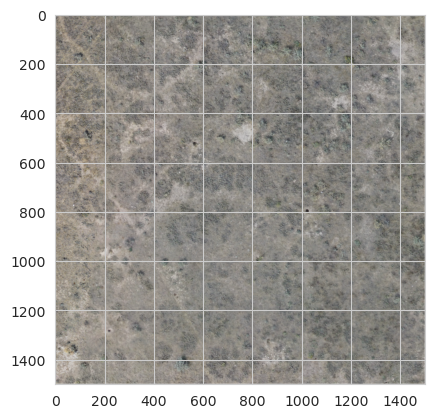

In [124]:
plt.imshow(rgb_out.transpose((1, 2, 0)).astype('int'))
plt.show()

In [138]:
np.unique(pr_mask)

array([0., 1.])

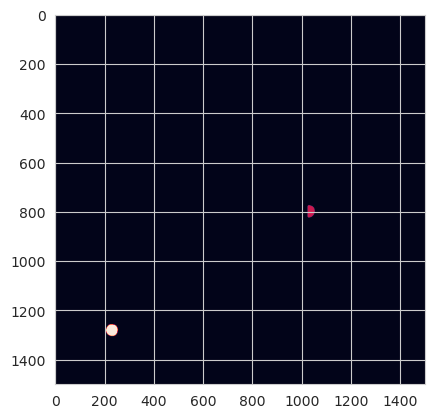

In [139]:
plt.imshow(pr_labels)
plt.show()

In [140]:
df_bboxes_tmp

,ID,Pasture,Tile,min_x,min_y,Type,Train,Digitize,Poly_ID,max_x,max_y,img_group,path_pre,pred_ct,pred_correct_ct,label_ct,label_correct_ct,gt_ct
11,22E_11,22E,burrows_active_0,520413.0,4518287.0,burrows_active,0,0,22e,520443.0,4518317.0,group_2,train_tiles/22E_burrows_active/22E_burrows_act...,2.0,2.0,0.0,0.0,8.0
12,22E_12,22E,burrows_active_1,520413.0,4518317.0,burrows_active,0,1,22e,520443.0,4518347.0,group_2,train_tiles/22E_burrows_active/22E_burrows_act...,NaN,NaN,NaN,NaN,NaN
13,22E_13,22E,burrows_active_2,520443.0,4518287.0,burrows_active,0,1,22e,520473.0,4518317.0,group_2,train_tiles/22E_burrows_active/22E_burrows_act...,NaN,NaN,NaN,NaN,NaN
14,22E_14,22E,burrows_active_3,520443.0,4518317.0,burrows_active,0,0,22e,520473.0,4518347.0,group_2,train_tiles/22E_burrows_active/22E_burrows_act...,NaN,NaN,NaN,NaN,NaN
9,22W_9,22W,burrows_active_0,519939.0,4518750.0,burrows_active,0,0,22w,519969.0,4518780.0,group_1,train_tiles/22W_burrows_active/22W_burrows_act...,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46,CN_46,CN,burrows_active_19,519797.0,4516651.0,burrows_active,0,1,cn2,519827.0,4516681.0,group_3,train_tiles/CN_burrows_active/CN_burrows_activ...,NaN,NaN,NaN,NaN,NaN
47,CN_47,CN,burrows_active_20,519797.0,4516681.0,burrows_active,0,0,cn2,519827.0,4516711.0,group_3,train_tiles/CN_burrows_active/CN_burrows_activ...,NaN,NaN,NaN,NaN,NaN
48,CN_48,CN,burrows_active_21,519827.0,4516621.0,burrows_active,0,0,cn2,519857.0,4516651.0,group_3,train_tiles/CN_burrows_active/CN_burrows_activ...,NaN,NaN,NaN,NaN,NaN
49,CN_49,CN,burrows_active_22,519827.0,4516651.0,burrows_active,0,1,cn2,519857.0,4516681.0,group_3,train_tiles/CN_burrows_active/CN_burrows_activ...,NaN,NaN,NaN,NaN,NaN


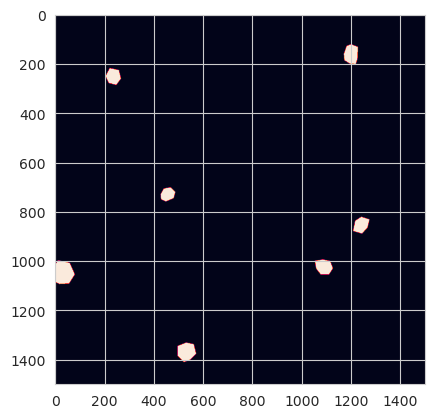

In [74]:
#print(ID)
# get the path base to the imagery associated with the training tile
if external_path is None:
    tilePATH = df_tiles[df_tiles['ID'] == ID]['path_pre'].iloc[0]
else:
    tilePATH = os.path.join(external_path,
                            df_tiles[df_tiles['ID'] == ID]['path_pre'].iloc[0])
# get the x/y coordinates of the bounding box for the training polygon within the tile
box_coords_x = df_tiles[df_tiles['ID'] == ID][['min_x', 'max_x']].iloc[0].values
box_coords_y = df_tiles[df_tiles['ID'] == ID][['min_y', 'max_y']].iloc[0].values
# get the box coordinate pairs
ll, ul, lr, ur = list(itertools.product(box_coords_x, box_coords_y))
# create a polygon from the coordinate pairs
tile_geom = Polygon([ll, ul, ur, lr])
# create the full path to the RGB image of the training tile
rgb_path = tilePATH + 'rgb.tif'
with rio.open(rgb_path) as src_rgb:   
    rgb_out, transform_out = mask.mask(src_rgb,
                                       [tile_geom],
                                       crop=True)
    ll_i = src_rgb.index(*ll)
    ur_i = src_rgb.index(*ur)
    gdf_polys_sub = gdf_polys[gdf_polys['Tile'] == ID]
    if len(gdf_polys_sub) > 0:
        label_mask = rasterize(gdf_polys_sub.geometry, 
                          out_shape=rgb_out.shape[1:], transform=transform_out,
                          default_value=1)
    else:
         label_mask = np.zeros_like(rgb_out[0, :, :])   

newsize_r = int(round((box_coords_y[1] - box_coords_y[0]) / (res * 0.01), 0))
newsize_c = int(round((box_coords_x[1] - box_coords_x[0]) / (res * 0.01), 0))
rgb_out = resize(rgb_out.transpose((1, 2, 0)),
                 (newsize_r, newsize_c, 3), 
                 anti_aliasing=True, 
                 order=1).transpose((2, 0, 1))
label_mask = label_mask.astype('float')
label_mask = resize(label_mask,
                 (newsize_r, newsize_c), 
                 anti_aliasing=True, 
                 order=1)
label_mask = label_mask >= 0.5
label_mask = label_mask.astype('int')
plt.imshow(label_mask)
plt.show()

In [35]:
precision = np.sum(precision_list) / len(precision_list)
recall = np.sum(recall_list) / len(recall_list)
burrow_test_result = {'model': model_fnl,
                      'inputs': inputs_fnl,
                      'precision': precision,
                      'recall': recall,
                      'fscore': (2 * precision * recall) / (precision + recall),
                      'corr': np.corrcoef(burrow_ct_gt, burrow_ct_pred)[0, 1]}

with open(os.path.join(outDIR_mod, 'test_valid_burrow.json'), 'w') as dst:
    json.dump(burrow_test_result, dst)

plt.figure(figsize=(8, 8))
plt.scatter(x=burrow_ct_gt, y=burrow_ct_pred)
plt.xlabel('Burrow ct (observed)')
plt.ylabel('Burrow ct (predicted)')
plt.plot(np.arange(0, 16), np.arange(0, 16), c='black')
#obtain m (slope) and b(intercept) of linear regression line
m, b = np.polyfit(burrow_ct_gt, burrow_ct_pred, 1)
#add linear regression line to scatterplot 
plt.plot(np.arange(0, 16), m*np.arange(0, 16)+b, 
         linestyle='dashed', c='black')

if True:
    for i in range(len(burrow_ct_gt)):
        plt.text(x=burrow_ct_gt[i]+0.25,
                 y=burrow_ct_pred[i],
                 s=tile_id_list[i])
plt.savefig(os.path.join(outDIR_mod, 'test_valid_burrow_correlation.png'), dpi=300)
plt.close()

### Test against ground data

preprocess = True
df_bboxes_tmp = df_bboxes_all.copy()
gdf_pdog_points_tmp = gdf_pdog_points.copy()
print('...running burrow-scale test validation with ground-truth data')
for ID in df_bboxes_all['ID'][df_bboxes_all['Type'] != 'non_burrows']:
    #print(ID)
    # get the path base to the imagery associated with the training tile
    if external_path is None:
        tilePATH = df_bboxes_all[df_bboxes_all['ID'] == ID]['path_pre'].iloc[0]
    else:
        tilePATH = os.path.join(external_path,
                                df_bboxes_all[df_bboxes_all['ID'] == ID]['path_pre'].iloc[0])
    # get the x/y coordinates of the bounding box for the training polygon within the tile
    box_coords_x = df_bboxes_all[df_bboxes_all['ID'] == ID][['min_x', 'max_x']].iloc[0].values
    box_coords_y = df_bboxes_all[df_bboxes_all['ID'] == ID][['min_y', 'max_y']].iloc[0].values
    # get the box coordinate pairs
    ll, ul, lr, ur = list(itertools.product(box_coords_x, box_coords_y))
    # create a polygon from the coordinate pairs
    tile_geom = Polygon([ll, ul, ur, lr])
    # create the full path to the RGB image of the training tile
    rgb_path = tilePATH + 'rgb.tif'
    with rio.open(rgb_path) as src_rgb:   
        profile_rgb = src_rgb.meta
        rgb_out, transform_out = mask.mask(src_rgb,
                                           [tile_geom],
                                           crop=True)
        rgb_out = rgb_out.astype('int')
        #rgb_out = rgb_out[:, -win_size:, :win_size]
        #show(rgb_out)
        ll_i = src_rgb.index(*ll)
        ur_i = src_rgb.index(*ur)
        gdf_polys_sub = gdf_polys[gdf_polys['Tile'] == ID]
        if len(gdf_polys_sub) > 0:
            label_mask = rasterize(gdf_polys_sub.geometry, 
                              out_shape=rgb_out.shape[1:], transform=transform_out,
                              default_value=1)
        else:
             label_mask = np.zeros_like(rgb_out[0, :, :])   
        #label = label[ll_i[0]:ur_i[0], ll_i[1]:ur_i[1]]
        profile_rgb.update({'dtype': 'int16',
                            'height': rgb_out.shape[0],
                            'width': rgb_out.shape[1],
                            'transform': transform_out})
        profile_single = profile_rgb.copy()
        profile_single.update({'count': 1})
        profile_single_float = profile_single.copy()
        profile_single_float.update({'dtype': 'float64'})
        #show(label)

    n_row_chunks = int(np.ceil(rgb_out.shape[1]/256))
    n_col_chunks = int(np.ceil(rgb_out.shape[2]/256))

    pr_mask = np.empty_like(rgb_out[0, :, :])
    image_dict = {}
    for suffix in inputs_fnl:
        with rio.open(re.sub('rgb', suffix, rgb_path)) as src_i:
            i_out = src_i.read(out_shape=(
                src_i.count,
                src_rgb.meta['height'],
                src_rgb.meta['width']),
                               resampling=Resampling.bilinear)
            image_dict[suffix] = i_out[:, ll_i[1]-1:ur_i[1]+1, ur_i[0]-1:ll_i[0]+1]
    image_sub_dict = {}
    for r in range(n_row_chunks):
        if (r + 1) * 256 > rgb_out.shape[1]:
            r_min = rgb_out.shape[1] - 256
            r_max = rgb_out.shape[1]
        else:
            r_min = r * 256
            r_max = (r + 1) * 256
        for c in range(n_col_chunks):
            if (c + 1) * 256 > rgb_out.shape[2]:
                c_min = rgb_out.shape[2] - 256
                c_max = rgb_out.shape[2]
            else:
                c_min = c * 256
                c_max = (c + 1) * 256
            for k in image_dict:
                image_sub_dict[k] = image_dict[k][:, r_min:r_max, c_min:c_max].astype('float32')
            if 'rgb' in inputs_fnl:
                image_sub_dict['rgb'] = rgb_out[:, r_min:r_max, c_min:c_max].astype('float32')
            if preprocess:
                for i in image_sub_dict:
                    image_sub_dict[i] = normalize_fn(image_sub_dict[i], i, image_stats)
            image_list = [image_sub_dict[i] for i in inputs_fnl]
            image_out = np.concatenate(image_list, axis=0)
            x_tensor = torch.from_numpy(image_out).to(DEVICE).unsqueeze(0)
            if type(best_model) == nn.DataParallel:
                pr_mask[r_min:r_max, c_min:c_max] = best_model.module.predict(x_tensor).cpu().detach().numpy().squeeze() > 0.5
            else:
                pr_mask[r_min:r_max, c_min:c_max] = best_model.predict(x_tensor).cpu().detach().numpy().squeeze() > 0.5

    # create mask of ground-truth polygon
    gt_plot_mask = rasterize(gdf_plots_all.geometry, 
                             out_shape=rgb_out.shape[1:], transform=transform_out,
                             default_value=1)

    # get predictions for ground-truth points
    gdf_pdog_points_sub = gdf_pdog_points[gdf_pdog_points.geometry.within(tile_geom)]
    if len(gdf_pdog_points_sub) > 0:
        all_points_mask = rasterize(gdf_pdog_points_sub.geometry.buffer(0.5), 
                                      out_shape=rgb_out.shape[1:], transform=transform_out,
                                      default_value=1)      
    else:
        all_points_mask = np.zeros_like(rgb_out[0, :, :]) 

    # mask all arrays to ground-truth polygon
    pr_mask = pr_mask * gt_plot_mask
    label_mask = label_mask * gt_plot_mask
    all_points_mask = all_points_mask * gt_plot_mask


    # get regions and properties of the ground truth and predictions
    label_labels = label(label_mask)
    label_regions = regionprops(label_labels)
    pr_labels = label(pr_mask)
    pr_regions = regionprops(pr_labels)

    ground_pred_precision_list = []
    ground_label_precision_list = []
    r_ct_pred = 0
    for r in pr_regions:
        if r.area*src_rgb.meta['transform'][0]**2 > 0.05:
            y_pr, x_pr = r.centroid
            ground_pred_precision_list.append(all_points_mask[int(y_pr), int(x_pr)])
            r_ct_pred += 1

    r_ct_label = 0
    for r in label_regions:
        y_label, x_label = r.centroid
        ground_label_precision_list.append(all_points_mask[int(y_label), int(x_label)])
        r_ct_label += 1

    df_bboxes_tmp.loc[df_bboxes_tmp['ID'] == ID, 'pred_ct'] = len(ground_pred_precision_list)
    df_bboxes_tmp.loc[df_bboxes_tmp['ID'] == ID, 'pred_correct_ct'] = np.sum(ground_pred_precision_list)
    df_bboxes_tmp.loc[df_bboxes_tmp['ID'] == ID, 'label_ct'] = len(ground_label_precision_list)
    df_bboxes_tmp.loc[df_bboxes_tmp['ID'] == ID, 'label_correct_ct'] = np.sum(ground_label_precision_list)
    df_bboxes_tmp.loc[df_bboxes_tmp['ID'] == ID, 'gt_ct'] = len(gdf_pdog_points_sub[gdf_pdog_points_sub['is_burrow'] == 1])

    if len(gdf_pdog_points_sub) > 0:
        for idx, point in gdf_pdog_points_sub.iterrows():
            point_mask = rasterize([point.geometry.buffer(0.5)], 
                                  out_shape=rgb_out.shape[1:], transform=transform_out,
                                  default_value=1)
            point_labels = label(point_mask)
            point_regions = regionprops(point_labels)
            y_gt, x_gt = point_regions[0].centroid
            gdf_pdog_points_tmp.loc[idx, 'pred'] = pr_mask[int(y_gt), int(x_gt)]
            gdf_pdog_points_tmp.loc[idx, 'label'] = label_mask[int(y_gt), int(x_gt)]

df_bboxes_tmp['model'] = model_fnl
df_bboxes_tmp['inputs'] = '_'.join(inputs_fnl)
df_bboxes_tmp.to_csv(os.path.join(outDIR_mod, 'test_valid_bbox_gt.csv'), index=False)

gdf_pdog_points_tmp['model'] = model_fnl
gdf_pdog_points_tmp['inputs'] = '_'.join(inputs_fnl)
gdf_pdog_points_tmp.to_csv(os.path.join(outDIR_mod, 'test_valid_burrow_gt.csv'), index=False)

del best_model, df_bboxes_tmp, gdf_pdog_points_tmp, logs, burrow_test_result

...running burrow-scale test validation with ground-truth data
comparing to ground data
comparing to ground data
comparing to ground data
comparing to ground data
comparing to ground data
comparing to ground data
comparing to ground data
comparing to ground data
comparing to ground data
comparing to ground data
comparing to ground data
comparing to ground data
comparing to ground data
comparing to ground data
comparing to ground data
comparing to ground data
comparing to ground data
comparing to ground data
comparing to ground data
comparing to ground data
comparing to ground data
comparing to ground data
comparing to ground data
comparing to ground data
comparing to ground data
comparing to ground data
comparing to ground data
comparing to ground data
comparing to ground data
comparing to ground data
comparing to ground data
comparing to ground data
comparing to ground data
comparing to ground data
comparing to ground data
comparing to ground data
comparing to ground data
comparing to

ValueError: Length of values (5) does not match length of index (92)

In [39]:
df_burrow_ct_tmp = pd.DataFrame({'tile_id': tile_id_list,
                                'burrow_ct_gt': burrow_ct_gt,
                                'burrow_ct_pred': burrow_ct_pred})
df_burrow_ct_tmp.to_csv(os.path.join(outDIR_mod, 'test_valid_burrow_count.csv'), index=False)

In [37]:
df_bboxes_tmp['model'] = model_fnl
df_bboxes_tmp['inputs'] = '_'.join(inputs_fnl)
df_bboxes_tmp.to_csv(os.path.join(outDIR_mod, 'test_valid_bbox_gt.csv'), index=False)

gdf_pdog_points_tmp['model'] = model_fnl
gdf_pdog_points_tmp['inputs'] = '_'.join(inputs_fnl)
gdf_pdog_points_tmp.to_csv(os.path.join(outDIR_mod, 'test_valid_burrow_gt.csv'), index=False)

In [45]:
print('Prediction precision by Pasture')
df_bboxes_all.groupby('Pasture').apply(lambda x: x['pred_correct_ct'].sum()/x['pred_ct'].sum())

Prediction precision by Pasture


Pasture
22E      0.826087
22W      0.733333
29-30    0.846154
5W       0.255556
CN       0.810526
dtype: float64

In [46]:
print('Prediction recall by Pasture')
gdf_pdog_points.groupby('Pasture').apply(lambda x: ((x['is_burrow'] == 1) &
                                                    (x['pred'] == 1)).sum() / (x['is_burrow'] == 1).sum())

Prediction recall by Pasture


Pasture
22E      0.612903
22W      0.904762
29-30    0.729412
5W       0.630435
CN       0.777778
dtype: float64

In [47]:
pred_corr = np.corrcoef(df_bboxes_all['gt_ct'], df_bboxes_all['pred_ct'])[0, 1]
print('Prediction correlation')
pred_corr
#label_corr = np.corrcoef(df_bboxes_all['gt_ct'], df_bboxes_all['label_ct'])[0, 1]

Prediction correlation


0.7413361816601182

In [48]:
ground_pred_recall = ((gdf_pdog_points['is_burrow'] == 1) & 
                      (gdf_pdog_points['pred'] == 1)).sum() / (gdf_pdog_points['is_burrow'] == 1).sum()
print('Prediction recall')
ground_pred_recall

Prediction recall


0.7304964539007093

In [49]:
print('Prediction error rate')
((gdf_pdog_points['is_burrow'] == 0) & 
 (gdf_pdog_points['pred'] == 1)).sum() / (gdf_pdog_points['pred'] == 1).sum()

Prediction error rate


0.10434782608695652

In [50]:
print('Prediction error partition for non-burrows')
gdf_pdog_points[gdf_pdog_points['is_burrow'] == 0].groupby('Comment').apply(lambda x: ((x['pred'] == 1)).sum() / len(x['pred']))

Prediction error partition for non-burrows


Comment
ant    0.089552
den    0.875000
dig    0.500000
old    0.259259
dtype: float64

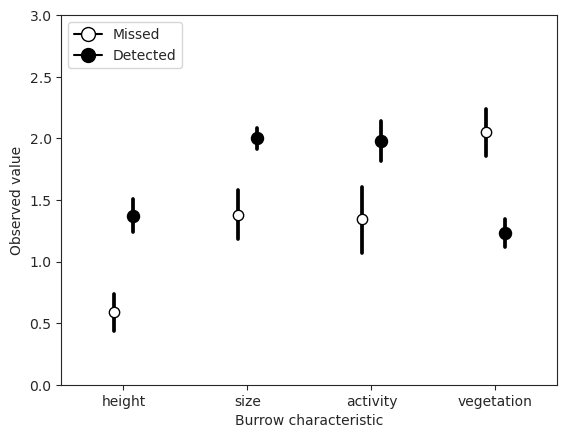

In [51]:
plt.close()
from matplotlib.lines import Line2D
sns.set_style("ticks")
gdf_pdog_points_long = pd.melt(gdf_pdog_points[gdf_pdog_points['is_burrow'] == 1],
                               id_vars=['Pasture', 'is_burrow', 'pred', 'label'],
                               value_vars=['height', 'size', 'activity', 'vegetation'])
g=sns. pointplot(x='variable', y='value', data=gdf_pdog_points_long, kind='point',
            hue='pred', join=False, dodge=0.15, markers='o', scale=1.1, palette={0.0: 'black', 1.0: 'black'}, ec=['black', 'none'])
#g.set_facecolor('blue')
g.set_ylim(0, 3)
g.legend().remove()
p1=g.get_children()[4]
p1.set_facecolor('white')
p1.set_linewidth(1)
g.set_xlabel('Burrow characteristic')
g.set_ylabel('Observed value')

legend_elements = [Line2D([0], [0], marker='o', color='black', label='Missed',
                          markerfacecolor='white', markersize=10),
                  Line2D([0], [0], marker='o', color='black', label='Detected',
                          markerfacecolor='black', markersize=10)]

g.legend(handles=legend_elements, loc='upper left')
plt.show(g)

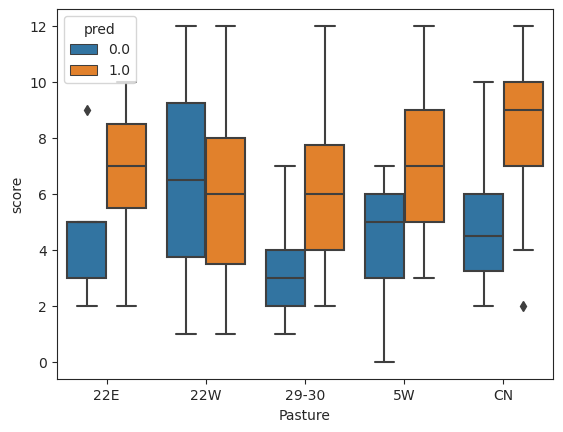

In [52]:
gdf_pdog_points['score'] = gdf_pdog_points.apply(lambda x: x['height'] + x['size'] + x['activity'] + (3.0 - x['vegetation']), axis=1)
sns.boxplot(x='Pasture', y='score', data=gdf_pdog_points[gdf_pdog_points['is_burrow'] == 1],
            hue='pred')
plt.show()

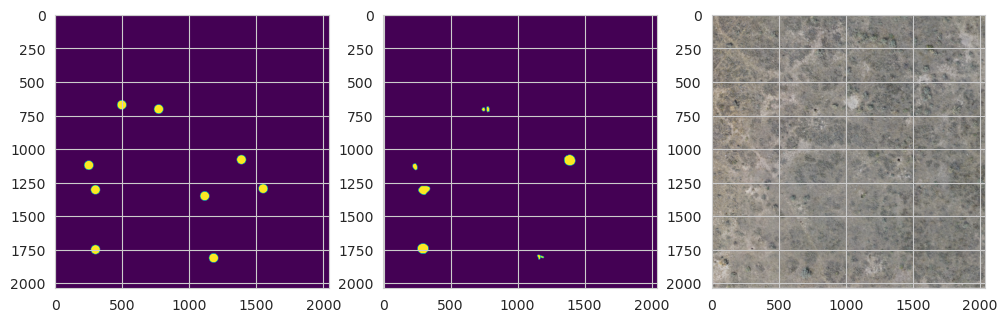

In [83]:
plt.close()
fig, axs = plt.subplots(figsize=(12, 6), nrows=1, ncols=3)
axs[0].imshow(all_points_mask, cmap='viridis')
axs[1].imshow(pr_mask, cmap='viridis')
axs[2].imshow(rgb_out.transpose((1, 2, 0)))
plt.show()

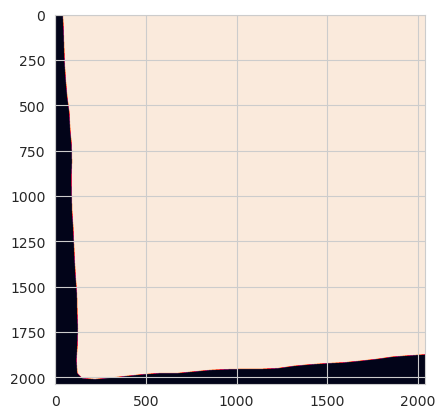

In [84]:
plt.imshow(gt_plot_mask)
plt.show()

In [59]:
pred_precision = np.sum(ground_pred_precision_list) / len(ground_pred_precision_list)
label_precision = np.sum(ground_label_precision_list) / len(ground_label_precision_list)
#recall = np.sum(recall_list) / len(recall_list)
#fscore = (2 * precision * recall) / (precision + recall)
pred_corr = np.corrcoef(ground_burrow_ct_gt, ground_burrow_ct_pred)[0, 1]
label_corr = np.corrcoef(ground_burrow_ct_gt, ground_burrow_ct_label)[0, 1]

In [61]:
print('--- Results for ' + str(len(ground_tile_id_list)) + ' test tiles (excluding predicted burrows < 0.05 m^2) ---')
print('Prediction precision: ' + str(round(pred_precision, 2)))
#print('recall: ' + str(round(recall, 2)))
#print('f-score: ' + str(round(fscore, 2)))
print('Prediciton burrow count correlation: ' + str(round(pred_corr, 2)))

print('Label precision: ' + str(round(label_precision, 2)))
print('Label burrow count correlation: ' + str(round(label_corr, 2)))

--- Results for 75 test tiles (excluding predicted burrows < 0.05 m^2) ---
Prediction precision: 0.36
Prediciton burrow count correlation: 0.59
Label precision: 0.39
Label burrow count correlation: 0.31


In [152]:
gdf_pdog_points_test = gdf_pdog_points[~gdf_pdog_points['pred'].isnull()].copy()
gdf_pdog_points_test['score'] = gdf_pdog_points_test.apply(lambda x: x['height'] + x['size'] + x['activity'] + (3.0 - x['vegetation']), axis=1)

In [153]:
gpred_recall = ((gdf_pdog_points_test['is_burrow'] == 1) & 
                   (gdf_pdog_points_test['pred'] == 1)).sum() / (gdf_pdog_points_test['is_burrow'] == 1).sum()
glabel_recall = ((gdf_pdog_points_test['is_burrow'] == 1) & 
                   (gdf_pdog_points_test['label'] == 1)).sum() / (gdf_pdog_points_test['is_burrow'] == 1).sum()
#fscore = (2 * precision * recall) / (precision + recall)

In [162]:
gpred_recall

0.6629213483146067

In [155]:
gdf_pdog_points_test[(gdf_pdog_points_test['is_burrow'] == 1) & 
                   (gdf_pdog_points_test['pred'] == 0)]['score'].mean()

4.666666666666667

In [156]:
gdf_pdog_points_test['score'].mean()

6.168539325842697

In [161]:
gdf_pdog_points_test[gdf_pdog_points_test['is_burrow'] == 1]

,Comment,Pasture,height,size,activity,vegetation,is_burrow,geometry,pred,label,score
0,h0s1a2v2,22E,0.0,1.0,2.0,2.0,1,POINT Z (520461.553 4518295.570 1620.810),0.0,1.0,4.0
1,h2s1a3v1,22E,2.0,1.0,3.0,1.0,1,POINT Z (520452.430 4518297.281 1620.839),1.0,1.0,8.0
2,h0s0a1v2,22E,0.0,0.0,1.0,2.0,1,POINT Z (520450.601 4518299.095 1620.966),1.0,1.0,2.0
3,h1s1a2v2,22E,1.0,1.0,2.0,2.0,1,POINT Z (520443.890 4518293.633 1619.823),1.0,0.0,5.0
4,h1s1a2v3,22E,1.0,1.0,2.0,3.0,1,POINT Z (520435.802 4518297.874 1620.709),0.0,0.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...
357,h1s2a0v1,5W,1.0,2.0,0.0,1.0,1,POINT Z (525653.756 4523436.086 1627.086),1.0,0.0,5.0
358,h0s2a0v2,5W,0.0,2.0,0.0,2.0,1,POINT Z (525659.512 4523419.659 1626.964),1.0,0.0,3.0
359,h0s0a0v3,5W,0.0,0.0,0.0,3.0,1,POINT Z (525659.916 4523420.353 1626.968),0.0,0.0,0.0
361,h0s2a0v1,5W,0.0,2.0,0.0,1.0,1,POINT Z (525656.319 4523393.642 1626.979),1.0,0.0,4.0


In [54]:
ID = '5W_20'
print(ID)
# get the path base to the imagery associated with the training tile
if external_path is None:
    tilePATH = df_bboxes_all[df_bboxes_all['ID'] == ID]['path_pre'].iloc[0]
else:
    tilePATH = os.path.join(external_path,
                            df_bboxes_all[df_bboxes_all['ID'] == ID]['path_pre'].iloc[0])
# get the x/y coordinates of the bounding box for the training polygon within the tile
box_coords_x = df_bboxes_all[df_bboxes_all['ID'] == ID][['min_x', 'max_x']].iloc[0].values
box_coords_y = df_bboxes_all[df_bboxes_all['ID'] == ID][['min_y', 'max_y']].iloc[0].values
# get the box coordinate pairs
ll, ul, lr, ur = list(itertools.product(box_coords_x, box_coords_y))
# create a polygon from the coordinate pairs
tile_geom = Polygon([ll, ul, ur, lr])
# create the full path to the RGB image of the training tile
rgb_path = tilePATH + 'rgb.tif'
with rio.open(rgb_path) as src_rgb:   
    profile_rgb = src_rgb.meta
    rgb_out, transform_out = mask.mask(src_rgb,
                                       [tile_geom],
                                       crop=True)
    rgb_out = rgb_out.astype('int')
    #rgb_out = rgb_out[:, -win_size:, :win_size]
    #show(rgb_out)
    ll_i = src_rgb.index(*ll)
    ur_i = src_rgb.index(*ur)
    gdf_polys_sub = gdf_polys[gdf_polys['Tile'] == ID]
    if len(gdf_polys_sub) > 0:
        label_mask = rasterize(gdf_polys_sub.geometry, 
                          out_shape=rgb_out.shape[1:], transform=transform_out,
                          default_value=1)
    else:
         label_mask = np.zeros_like(rgb_out[0, :, :])   
    #label = label[ll_i[0]:ur_i[0], ll_i[1]:ur_i[1]]
    profile_rgb.update({'dtype': 'int16',
                        'width': rgb_out.shape[0],
                        'height': rgb_out.shape[1],
                        'transform': transform_out})
    profile_single = profile_rgb.copy()
    profile_single.update({'count': 1})
    profile_single_float = profile_single.copy()
    profile_single_float.update({'dtype': 'float64'})
    #show(label)

n_row_chunks = int(np.ceil(rgb_out.shape[1]/256))
n_col_chunks = int(np.ceil(rgb_out.shape[2]/256))

pr_mask = np.empty_like(rgb_out[0, :, :])
pr_mask = np.empty_like(rgb_out[0, :, :])
image_dict = {}
for suffix in inputs_fnl:
    with rio.open(re.sub('rgb', suffix, rgb_path)) as src_i:
        i_out = src_i.read(out_shape=(
            src_i.count,
            src_rgb.meta['height'],
            src_rgb.meta['width']),
                           resampling=Resampling.bilinear)
        image_dict[suffix] = i_out[:, ll_i[1]:ur_i[1]+1, ur_i[0]:ll_i[0]+1]
if 'rgb' in inputs_fnl:
    image_dict['rgb'] = rgb_out
if preprocess:
    for i in image_dict:
        image_dict[i] = normalize_fn(image_dict[i], i, image_stats)
image_list = [image_dict[i].astype('float32') for i in inputs_fnl]
image_out = np.concatenate(image_list, axis=0)

chunksize = 256
pr_mask = np.empty_like(rgb_out[0, :, :])
n_row_chunks = int(np.ceil(rgb_out.shape[1]/chunksize))
n_col_chunks = int(np.ceil(rgb_out.shape[2]/chunksize))
image_sub_dict = {}
for r in range(n_row_chunks):
    if (r + 1) * chunksize > rgb_out.shape[1]:
        r_min = rgb_out.shape[1] - chunksize
        r_max = rgb_out.shape[1]
    else:
        r_min = r * chunksize
        r_max = (r + 1) * chunksize
    for c in range(n_col_chunks):
        if (c + 1) * chunksize > rgb_out.shape[2]:
            c_min = rgb_out.shape[2] - chunksize
            c_max = rgb_out.shape[2]
        else:
            c_min = c * chunksize
            c_max = (c + 1) * chunksize
        image_out_sub = image_out[:, r_min:r_max, c_min:c_max]
        x_tensor = torch.from_numpy(image_out_sub).to(DEVICE).unsqueeze(0)
        if type(best_model) == nn.DataParallel:
            pr_mask[r_min:r_max, c_min:c_max] = best_model.module.predict(x_tensor).cpu().detach().numpy().squeeze() > 0.5
        else:
            pr_mask[r_min:r_max, c_min:c_max] = best_model.predict(x_tensor).cpu().detach().numpy().squeeze() > 0.5

# create mask of ground-truth polygon
gt_plot_mask = rasterize(gdf_plots_all.geometry, 
                         out_shape=rgb_out.shape[1:], transform=transform_out,
                         default_value=1)

# get predictions for ground-truth points
gdf_pdog_points_sub = gdf_pdog_points[gdf_pdog_points.geometry.within(tile_geom)]
if len(gdf_pdog_points_sub) > 0:
    all_points_mask = rasterize(gdf_pdog_points_sub.geometry.buffer(0.5), 
                                  out_shape=rgb_out.shape[1:], transform=transform_out,
                                  default_value=1)      
else:
    all_points_mask = np.zeros_like(rgb_out[0, :, :]) 

# mask all arrays to ground-truth polygon
pr_mask = pr_mask * gt_plot_mask
label_mask = label_mask * gt_plot_mask
all_points_mask = all_points_mask * gt_plot_mask


# get regions and properties of the ground truth and predictions
label_labels = label(label_mask)
label_regions = regionprops(label_labels)
pr_labels = label(pr_mask)
pr_regions = regionprops(pr_labels)

ground_pred_precision_list = []
ground_label_precision_list = []
r_ct_pred = 0
for r in pr_regions:
    if r.area*src_rgb.meta['transform'][0]**2 > 0.05:
        y_pr, x_pr = r.centroid
        ground_pred_precision_list.append(all_points_mask[int(y_pr), int(x_pr)])
        r_ct_pred += 1

r_ct_label = 0
for r in label_regions:
    y_label, x_label = r.centroid
    ground_label_precision_list.append(all_points_mask[int(y_label), int(x_label)])
    r_ct_label += 1

5W_20


ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 1829 and the array at index 1 has size 1831

In [ ]:
plt.close()
fig, axs = plt.subplots(figsize=(12, 6), nrows=1, ncols=4)
axs[0].imshow(all_points_mask, cmap='viridis')
axs[1].imshow(pr_mask, cmap='viridis')
axs[2].imshow(label_mask, cmap='viridis')
axs[3].imshow(rgb_out.transpose((1, 2, 0)))
plt.show()

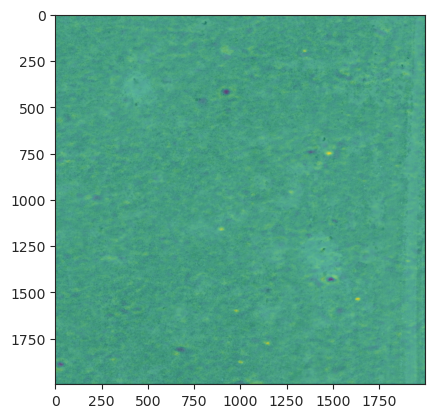

In [244]:
plt.imshow(image_dict['rgb'].transpose((1, 2, 0)))
plt.imshow(image_dict['tpi'].squeeze(), cmap='viridis', alpha=0.7)
plt.show()

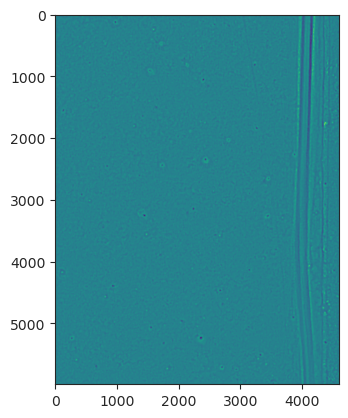

In [250]:
with rio.open(re.sub('rgb', 'tpi', rgb_path)) as src_i:
    i_out = src_i.read(out_shape=(
        src_i.count,
        src_rgb.meta['height'],
        src_rgb.meta['width']),
                       resampling=Resampling.bilinear)
plt.imshow(i_out.squeeze(), cmap='viridis')
plt.show()

In [249]:
i_out.shape

(1, 4591, 5989)

In [245]:
src_rgb.meta

{'driver': 'GTiff',
 'dtype': 'float64',
 'nodata': None,
 'width': 4591,
 'height': 5989,
 'count': 3,
 'crs': CRS.from_epsg(32613),
 'transform': Affine(0.015027257370912674, 0.0, 519939.0045268533,
        0.0, -0.015027257370897528, 4518839.99594921)}

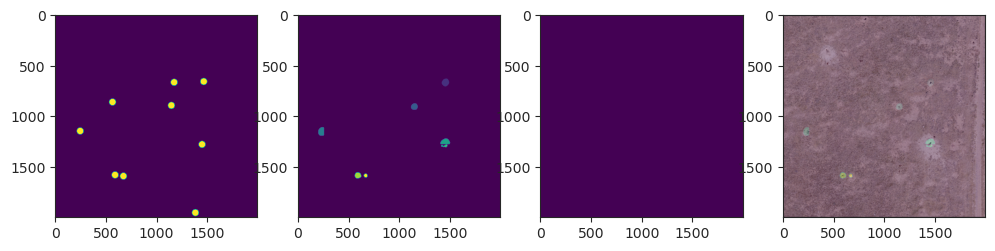

In [253]:
fig, axs = plt.subplots(figsize=(12, 6), nrows=1, ncols=4)
axs[0].imshow(all_points_mask, cmap='viridis')
axs[1].imshow(pr_labels, cmap='viridis')
axs[2].imshow(label_mask, cmap='viridis')
axs[3].imshow(rgb_out.transpose((1, 2, 0)))
axs[3].imshow(pr_labels, cmap='viridis', alpha=0.3)
plt.show()

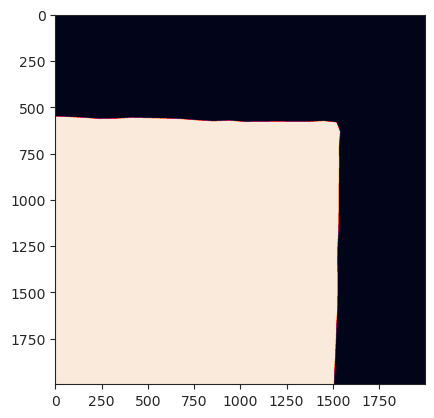

In [220]:
plt.imshow(gt_plot_mask)
plt.show()

In [ ]:
#if not os.path.exists('./cnn_results_' + model_fnl + '/test_predictions' + '_'.join(inputs_fnl)):
#    os.mkdir('./cnn_results_' + model_fnl + '/test_predictions' + '_'.join(inputs_fnl))
for i in range(10):
    n = np.random.choice(len(test_dataset))
    #n = i
    get_vis = test_dataset_vis[n]
    image_vis = test_dataset_vis.image_dict['rgb'].astype('uint8')
    image, gt_mask = test_dataset[n]
    
    gt_mask = gt_mask.squeeze()
    
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
        
    visualize(show=True,
                  write=False,
                  path='./cnn_results/test_predictions/' + 'pred_' + test_dataset_vis.ids[n] + '.png',
                  image=image_vis, 
                  ground_truth_mask=gt_mask, 
                  predicted_mask=pr_mask.squeeze()
            )

CN_50


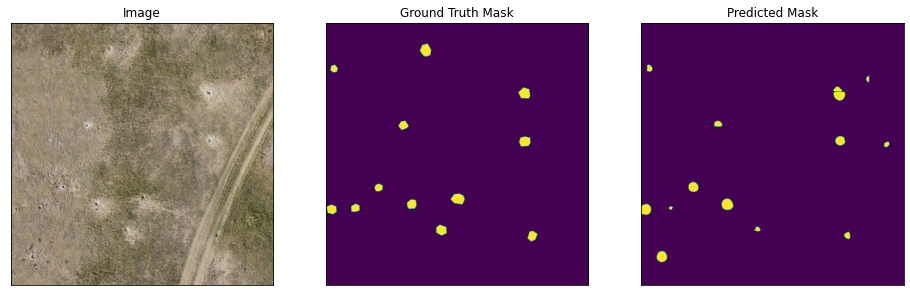

In [123]:
precision_list_sub = []
recall_list_sub = []
ID = 'CN_50'
if not all(df_tiles[df_tiles['ID'] == ID]['Train'] == 1):
    gdf_polys_sub = gdf_polys[gdf_polys['Tile'] == ID]
    print(ID)
    # get the path base to the imagery associated with the training tile
    tilePATH = df_tiles[df_tiles['ID'] == ID]['path_pre'].iloc[0]
    # get the x/y coordinates of the bounding box for the training polygon within the tile
    box_coords_x = df_tiles[df_tiles['ID'] == ID][['min_x', 'max_x']].iloc[0].values
    box_coords_y = df_tiles[df_tiles['ID'] == ID][['min_y', 'max_y']].iloc[0].values
    # get the box coordinate pairs
    ll, ul, lr, ur = list(itertools.product(box_coords_x, box_coords_y))
    # create a polygon from the coordinate pairs
    tile_geom = Polygon([ll, ul, ur, lr])
    # create the full path to the RGB image of the training tile
    rgb_path = tilePATH + 'rgb.tif'
    with rio.open(rgb_path) as src_rgb:   
        profile_rgb = src_rgb.meta
        rgb_out, transform_out = mask.mask(src_rgb,
                                           [tile_geom],
                                           crop=True)
        rgb_out = rgb_out.astype('int')
        #rgb_out = rgb_out[:, -win_size:, :win_size]
        #show(rgb_out)
        ll_i = src_rgb.index(*ll)
        ur_i = src_rgb.index(*ur)

        label_mask = rasterize(gdf_polys_sub.geometry, 
                          out_shape=rgb_out.shape[1:], transform=transform_out,
                          default_value=1)
        #label = label[ll_i[0]:ur_i[0], ll_i[1]:ur_i[1]]
        profile_rgb.update({'dtype': 'int16',
                            'width': rgb_out.shape[0],
                            'height': rgb_out.shape[1],
                            'transform': transform_out})
        profile_single = profile_rgb.copy()
        profile_single.update({'count': 1})
        profile_single_float = profile_single.copy()
        profile_single_float.update({'dtype': 'float64'})
        #show(label)

    n_row_chunks = int(np.ceil(rgb_out.shape[1]/256))
    n_col_chunks = int(np.ceil(rgb_out.shape[2]/256))

    pr_mask = np.zeros_like(rgb_out[0, :, :])
    image_dict = {}
    for suffix in inputs_fnl:
        with rio.open(re.sub('rgb', suffix, rgb_path)) as src_i:
            i_out = src_i.read(out_shape=(
                src_i.count,
                src_rgb.meta['width'],
                src_rgb.meta['height']),
                               resampling=Resampling.bilinear)
            image_dict[suffix] = i_out[:, ll_i[1]-1:ur_i[1]+1, ur_i[0]-1:ll_i[0]+1]
    image_sub_dict = {}
    for r in range(n_row_chunks):
        if (r + 1) * 256 > rgb_out.shape[1]:
            r_min = rgb_out.shape[1] - 256
            r_max = rgb_out.shape[1]
        else:
            r_min = r * 256
            r_max = (r + 1) * 256
        for c in range(n_col_chunks):
            if (c + 1) * 256 > rgb_out.shape[2]:
                c_min = rgb_out.shape[2] - 256
                c_max = rgb_out.shape[2]
            else:
                c_min = c * 256
                c_max = (c + 1) * 256
            for k in image_dict:
                image_sub_dict[k] = image_dict[k][:, r_min:r_max, c_min:c_max].astype('float32')
            if 'rgb' in inputs_fnl:
                image_sub_dict['rgb'] = rgb_out[:, r_min:r_max, c_min:c_max].astype('float32')
            image_list = [image_sub_dict[i] for i in inputs_fnl]
            image_out = np.concatenate(image_list, axis=0)
            x_tensor = torch.from_numpy(image_out).to(DEVICE).unsqueeze(0)
            pr_mask[r_min:r_max, c_min:c_max] = best_model.predict(x_tensor).cpu().detach().numpy().squeeze() > 0.5
            #if True:
            #    break
        #if True:
        #    break
        #    print('done')

    # get regions and properties of the ground truth and predictions
    label_labels = label(label_mask)
    label_regions = regionprops(label_labels)
    pr_labels = label(pr_mask)
    pr_regions = regionprops(pr_labels)
    
    for r in pr_regions:
        if r.area*src_rgb.meta['transform'][0]**2 > 0.01:
            y_pr, x_pr = r.centroid
            precision_list_sub.append(label_mask[int(y_pr), int(x_pr)])

    for r in label_regions:
        y_label, x_label = r.centroid
        recall_list_sub.append(pr_mask[int(y_label), int(x_label)])  
    
    
    visualize(show=True,
              write=False,
              image=rgb_out.transpose((1, 2, 0)), 
              ground_truth_mask=label_mask.squeeze(), 
              predicted_mask=pr_mask.squeeze()
        )

In [124]:
precision_sub = np.sum(precision_list_sub) / len(precision_list_sub)
recall_sub = np.sum(recall_list_sub) / len(recall_list_sub)
fscore_sub = (2 * precision_sub * recall_sub) / (precision_sub + recall_sub)

In [125]:
print('precision: ' + str(round(precision_sub, 2)))
print('recall: ' + str(round(recall_sub, 2)))
print('f-score: ' + str(round(fscore_sub, 2)))

precision: 0.79
recall: 0.83
f-score: 0.81


In [99]:
for r in label_regions:
    print(r.centroid)

(208.0, 245.1888775361261)
(408.4257377842284, 1367.9305757135946)
(924.8004747277297, 1506.991622451829)
(1306.0253290290539, 210.1131114973926)


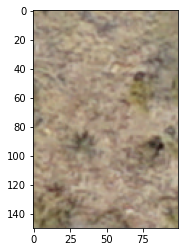

In [106]:
plt.imshow(rgb_out[:, 1200:1350, 150:250].transpose(1, 2, 0))

In [110]:
image_dict['shade'].shape

(1, 2039, 2039)

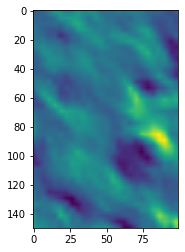

In [112]:
plt.imshow(image_dict['shade'][:, 1200:1350, 150:250].squeeze())

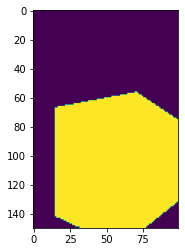

In [107]:
plt.imshow(label_mask[1200:1350, 150:250])

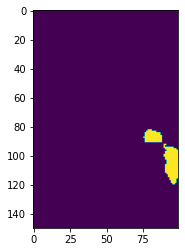

In [103]:
plt.imshow(pr_mask[1200:1350, 150:250])

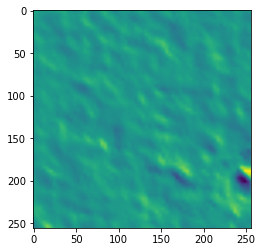

In [64]:
plt.imshow(image_out[3, :, :])

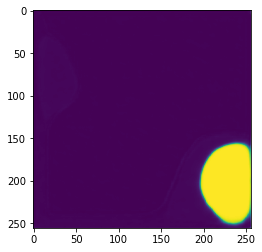

In [81]:
plt.imshow(best_model.predict(x_tensor).cpu().detach().numpy().squeeze())

In [85]:
pr_mask[r_min:r_max, c_min:c_max].dtype# = best_model.predict(x_tensor).cpu().detach().numpy().squeeze()

dtype('int64')

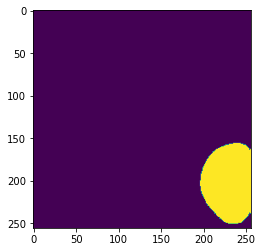

In [88]:
plt.imshow(pr_mask[r_min:r_max, c_min:c_max] > 0.5)

In [81]:


label_labels = label(label_mask)
label_regions = regionprops(label_labels)

pr_labels = label(pr_mask)
pr_regions = regionprops(pr_labels)

In [86]:
precision_list = []
for r in pr_regions:
    if r.area*src_rgb.meta['transform'][0]**2 > 0.01:
        y_pr, x_pr = r.centroid
        precision_list.append(label_mask[int(y_pr), int(x_pr)])

recall_list = []
for r in label_regions:
    y_label, x_label = r.centroid
    recall_list.append(pr_mask[int(y_label), int(x_label)])        

In [87]:
precision_list

[1, 1, 1]

In [88]:
recall_list

[1, 0, 1, 0]

In [74]:
src_rgb.meta['transform'][0]**2

0.0002166579681103332

In [ ]:
ID = 'CN_6'
gdf_polys_sub = gdf_polys[gdf_polys['Tile'] == ID]
print(ID)
# get the path base to the imagery associated with the training tile
tilePATH = df_tiles[df_tiles['ID'] == ID]['path_pre'].iloc[0]
# get the x/y coordinates of the bounding box for the training polygon within the tile
box_coords_x = df_tiles[df_tiles['ID'] == ID][['min_x', 'max_x']].iloc[0].values
box_coords_y = df_tiles[df_tiles['ID'] == ID][['min_y', 'max_y']].iloc[0].values
# get the box coordinate pairs
ll, ul, lr, ur = list(itertools.product(box_coords_x, box_coords_y))
# create a polygon from the coordinate pairs
tile_geom = Polygon([ll, ul, ur, lr])
# create the full path to the RGB image of the training tile
rgb_path = tilePATH + 'rgb.tif'
with rio.open(rgb_path) as src_rgb:   
    profile_rgb = src_rgb.meta
    rgb_out, transform_out = mask.mask(src_rgb,
                                       [tile_geom],
                                       crop=True)
    rgb_out = rgb_out.astype('int')
    #rgb_out = rgb_out[:, -win_size:, :win_size]
    show(rgb_out)
    ll_i = src_rgb.index(*ll)
    ur_i = src_rgb.index(*ur)

    label = rasterize(gdf_polys_sub.geometry, 
                      out_shape=rgb_out.shape[1:], transform=transform_out,
                      default_value=1)
    #label = label[ll_i[0]:ur_i[0], ll_i[1]:ur_i[1]]
    profile_rgb.update({'dtype': 'int16',
                        'width': rgb_out.shape[0],
                        'height': rgb_out.shape[1],
                        'transform': transform_out})
    profile_single = profile_rgb.copy()
    profile_single.update({'count': 1})
    profile_single_float = profile_single.copy()
    profile_single_float.update({'dtype': 'float64'})
    show(label)

n_row_chunks = int(np.ceil(rgb_out.shape[1]/256))
n_col_chunks = int(np.ceil(rgb_out.shape[2]/256))

pr_mask = np.empty_like(rgb_out[0, :, :])
for r in range(n_row_chunks):
    if (r + 1) * 256 > rgb_out.shape[1]:
        r_min = rgb_out.shape[1] - 256
        r_max = rgb_out.shape[1]
    else:
        r_min = r * 256
        r_max = (r + 1) * 256
    for c in range(n_col_chunks):
        if (c + 1) * 256 > rgb_out.shape[2]:
            c_min = rgb_out.shape[2] - 256
            c_max = rgb_out.shape[2]
        else:
            c_min = c * 256
            c_max = (c + 1) * 256
        rgb_sub = rgb_out[:, r_min:r_max, c_min:c_max]
        rgb_image_sub = preprocessing_fn(rgb_sub.transpose((1, 2, 0))).astype('float32').transpose((2, 0, 1))
        x_tensor = torch.from_numpy(rgb_image_sub).to(DEVICE).unsqueeze(0)
        pr_mask[r_min:r_max, c_min:c_max] = best_model.predict(x_tensor).cpu().squeeze()

visualize(
        image=rgb_out.transpose((1, 2, 0)), 
        ground_truth_mask=label.squeeze(), 
        predicted_mask=pr_mask.squeeze()
    )

In [44]:
os.path.basename(f).split('_'ascending=-1]

['rgb', 'tpi', 'shade', 'ndvi', 'dsm']

In [38]:
|

SyntaxError: invalid syntax (525519296.py, line 1)